# Week 7

## Lecture 13 - Inception, ResNet

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
GPU count: 1
Device 0: NVIDIA GeForce RTX 3080 Ti


### Reusable Training Function for CNNs and Image Datasets

We reuse code from Week 6. It is a function that allows us to input our dataset, model, and hyperparameters, which it then takes to train, save, and evaluate model performance.

We make a small adjustment to ingest a dataset in the form:

```
dataset/
├── train/
│   ├── class0/
│   ├── class1/
│   └── ...
└── valid/
    ├── class0/
    ├── class1/
    └── ...
```

In [2]:
# ======================================================================
# run_imagefolder_experiment
#
# End-to-end PyTorch training/evaluation pipeline for image classification
# using datasets stored in ImageFolder format.
#
# Features:
#   • Loads and splits dataset into train/val/test sets with configurable ratios.
#   • Applies augmentation to training set, standard transforms to val/test.
#   • Uses tqdm progress bars for batch-level metrics during training/validation/testing.
#   • Supports AdamW or SGD optimizers, label smoothing, gradient clipping.
#   • Includes ReduceLROnPlateau scheduler (default patience=10, factor=0.5).
#   • Includes early stopping (default patience=25) on validation metric.
#   • Saves best model checkpoint based on chosen monitor ("loss" or "acc").
#   • Evaluates on held-out test set with accuracy, confusion matrix, and classification report.
#   • Plots twin-axis training curves for loss and accuracy.
#
# Arguments:
#   data_dir (str): Root folder containing subfolders for the dataset (here, we assume train and
#                   valid subsets, with class subsets below that).
#   model (nn.Module): Model architecture to train.
#   [other arguments control preprocessing, training, and hyperparameters]
#
# Returns:
#   dict: history, best test accuracy, classes, checkpoint path, device info, total train time.
# ======================================================================
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import torch
import torch.nn as nn

from collections import Counter
from notebook.services.config import ConfigManager
from sklearn.metrics import confusion_matrix, classification_report
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.auto import tqdm

cm = ConfigManager()
cm.update('NotebookApp', {
    'iopub_msg_rate_limit': 50000,
    'rate_limit_window': 10.0
})

# ======================================================================
# Helper Functions
def split_counts(ds):
    """
    Return a Counter of class indices for either:
      - torchvision.datasets.ImageFolder
      - torch.utils.data.Subset(ImageFolder)
      - or any dataset exposing .samples or .targets; otherwise falls back to __getitem__
    """
    # If this is a Subset, unwrap to the base dataset and indices
    if isinstance(ds, torch.utils.data.Subset):
        base = ds.dataset
        idxs = ds.indices
        if hasattr(base, "samples"):
            labels = [base.samples[i][1] for i in idxs]
        elif hasattr(base, "targets"):
            labels = [base.targets[i] for i in idxs]
        else:
            # fallback (slower)
            labels = [base[i][1] for i in idxs]
    else:
        # Plain dataset (e.g., ImageFolder)
        if hasattr(ds, "samples"):
            labels = [y for _, y in ds.samples]
        elif hasattr(ds, "targets"):
            labels = list(ds.targets)
        else:
            # fallback (slower)
            labels = [ds[i][1] for i in range(len(ds))]

    return Counter(labels)

def current_lr(optim_):
    return optim_.param_groups[0]["lr"]

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()
# ======================================================================

def run_imagefolder_experiment(
    data_dir,
    model,
    *,
    img_size=224,
    resize_side=256,
    augment=True,
    normalize_stats=((0.485, 0.456, 0.406),
                     (0.229, 0.224, 0.225)),
    splits=(0.8, 0.1, 0.1),
    batch_train=32,
    batch_eval=64,
    num_workers=4,
    optimizer_name="adamw",
    lr=3e-4,
    weight_decay=5e-4,
    momentum=0.9,
    label_smoothing=0.03,
    epochs=1000,
    monitor="loss",
    min_delta=0.0,
    seed=0,
    grad_clip=None,
    patience=25,
    lr_patience=10,
    lr_factor=0.1,
    lr_min=1e-6,
    lr_cooldown=1,
    save_path="best_model.pth",
    use_aux=False,
    use_amp=False
):
    """Train/eval a model on an ImageFolder dataset.
       If `use_aux=True`, expects model to return (main_logits, aux_logits)
       and combines losses: loss = main_loss + 0.4 * aux_loss.
       If `use_amp=True`, enables mixed-precision (autocast + GradScaler) on CUDA.
    """
    # --- Device setup ---
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("[device] Using Apple Metal (MPS) device")
    else:
        device = torch.device("cpu")
        print("[device] Using CPU")
    print()

    torch.manual_seed(seed)
    np.random.seed(seed)
    model = model.to(device)

    # AMP context setup (only meaningful on CUDA)
    amp_enabled = bool(use_amp and device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

    mean, std = normalize_stats
    if augment:
        train_tf = transforms.Compose([
            transforms.Resize(resize_side),
            transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
    else:
        train_tf = transforms.Compose([
            transforms.Resize(resize_side),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    test_tf = transforms.Compose([
        transforms.Resize(resize_side),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # --- Dataset loading ---
    print(f"[data] Inspecting: {data_dir}")
    train_dir = os.path.join(data_dir, "train")
    valid_dir = os.path.join(data_dir, "valid")
    val_dir   = os.path.join(data_dir, "val")
    test_dir  = os.path.join(data_dir, "test")

    has_train = os.path.isdir(train_dir)
    has_valid = os.path.isdir(valid_dir) or os.path.isdir(val_dir)
    has_test  = os.path.isdir(test_dir)

    if has_train and has_valid:
        valid_root = valid_dir if os.path.isdir(valid_dir) else val_dir
        print("[data] Found explicit splits.")
        train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
        val_ds   = datasets.ImageFolder(valid_root, transform=test_tf)
        test_ds  = datasets.ImageFolder(test_dir, transform=test_tf) if has_test else \
                   datasets.ImageFolder(valid_root, transform=test_tf)
        classes = train_ds.classes
    else:
        full_ds = datasets.ImageFolder(root=data_dir, transform=train_tf)
        classes = full_ds.classes
        frac_train, frac_val, frac_test = splits
        N = len(full_ds)
        n_train = int(frac_train * N)
        n_val   = int(frac_val   * N)
        n_test  = N - n_train - n_val
        train_ds, val_ds, test_ds = random_split(
            full_ds, [n_train, n_val, n_test],
            generator=torch.Generator().manual_seed(seed)
        )
        train_ds.dataset.transform = train_tf
        val_ds.dataset.transform   = test_tf
        test_ds.dataset.transform  = test_tf

    # --- Dataloaders ---
    if num_workers is None:
        num_workers = min(4, os.cpu_count() or 0)
    pin_mem = (device.type == "cuda")

    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_mem)
    val_loader   = DataLoader(val_ds, batch_size=batch_eval, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_mem)
    test_loader  = DataLoader(test_ds, batch_size=batch_eval, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_mem)

    # --- Loss/optimizer/scheduler ---
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    monitor_metric = monitor.lower()
    sched_mode = "min" if monitor_metric == "loss" else "max"
    scheduler = ReduceLROnPlateau(
        optimizer, mode=sched_mode, factor=lr_factor, patience=lr_patience,
        threshold=min_delta, cooldown=lr_cooldown, min_lr=lr_min, verbose=True,
    )

    best_metric = 0.0 if monitor_metric == "acc" else float("inf")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    since_improved = 0

    # --- Training loop ---
    train_start_time = time.time()
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[epoch {epoch:03d} | train]", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            # Forward with autocast if AMP enabled
            if amp_enabled:
                with torch.cuda.amp.autocast():
                    outputs = model(x)
                    if use_aux and isinstance(outputs, (tuple, list)) and len(outputs) == 2:
                        logits, aux_logits = outputs
                        loss = criterion(logits, y) + 0.4 * criterion(aux_logits, y)
                    else:
                        logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
                        loss = criterion(logits, y)
                # Backward + step via GradScaler
                scaler.scale(loss).backward()
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                # Full precision path (explicitly not using AMP)
                outputs = model(x)
                if use_aux and isinstance(outputs, (tuple, list)) and len(outputs) == 2:
                    logits, aux_logits = outputs
                    loss = criterion(logits, y) + 0.4 * criterion(aux_logits, y)
                else:
                    logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
                    loss = criterion(logits, y)
                loss.backward()
                if grad_clip is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            bs = x.size(0)
            running_loss   += loss.item() * bs
            running_correct += (logits.argmax(1) == y).sum().item()
            total          += bs
            pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

        train_loss = running_loss / total
        train_acc  = running_correct / total

        # --- Validation ---
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        pbar_val = tqdm(val_loader, desc=f"[epoch {epoch:03d} | val  ]", leave=False)
        with torch.no_grad():
            # Autocast for eval only changes dtype; no GradScaler here.
            if amp_enabled:
                autocast_ctx = torch.cuda.amp.autocast()
            else:
                # Explicitly disable autocast when AMP is off
                class _NullCtx:
                    def __enter__(self): return None
                    def __exit__(self, exc_type, exc, tb): return False
                autocast_ctx = _NullCtx()

            with autocast_ctx:
                for x, y in pbar_val:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    if use_aux and isinstance(outputs, (tuple, list)) and len(outputs) == 2:
                        logits, aux_logits = outputs
                        loss = criterion(logits, y) + 0.4 * criterion(aux_logits, y)
                    else:
                        logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
                        loss = criterion(logits, y)

                    bs = x.size(0)
                    v_loss    += loss.item() * bs
                    v_correct += (logits.argmax(1) == y).sum().item()
                    v_total   += bs
                    pbar_val.set_postfix(loss=v_loss/v_total, acc=v_correct/v_total)

        val_loss = v_loss / v_total
        val_acc  = v_correct / v_total
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

        print(f"[epoch {epoch:03d}] train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | time: {time.time() - epoch_start_time:.2f}s")

        monitored_value = val_loss if monitor_metric == "loss" else val_acc
        scheduler.step(monitored_value)

        improved = (monitor_metric == "acc" and val_acc > best_metric + min_delta) or \
                   (monitor_metric == "loss" and val_loss < best_metric - min_delta)

        if improved:
            best_metric = val_acc if monitor_metric == "acc" else val_loss
            since_improved = 0
            torch.save(
                {"model_state": model.state_dict(),
                 "history": history,
                 "classes": classes,
                 "monitor": monitor,
                 "best_metric": best_metric},
                save_path
            )
            tqdm.write(f"  [checkpoint] New best ({monitor_metric}={best_metric:.4f}) saved -> {save_path}")
        else:
            since_improved += 1
            tqdm.write(f"  [early-stop] No improvement ({since_improved}/{patience}) "
                       f"on {monitor_metric}; best={best_metric:.4f}, current={monitored_value:.4f}")
            if since_improved >= patience:
                tqdm.write("  [early-stop] Patience exceeded — stopping.")
                break

    total_train_time = time.time() - train_start_time

    # --- Testing ---
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    history = ckpt["history"]
    classes = ckpt["classes"]

    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        # Eval autocast (again, only dtype; no scaler)
        if amp_enabled:
            autocast_ctx = torch.cuda.amp.autocast()
        else:
            class _NullCtx:
                def __enter__(self): return None
                def __exit__(self, exc_type, exc, tb): return False
            autocast_ctx = _NullCtx()

        with autocast_ctx:
            for x, y in tqdm(test_loader, desc="[test]", leave=False):
                x = x.to(device)
                outputs = model(x)
                logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
                preds = logits.argmax(1).cpu().numpy()
                all_preds.append(preds)
                all_trues.append(y.numpy())

    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    test_acc = (y_true == y_pred).mean()
    print(f"[eval] Test accuracy: {test_acc:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    # --- Plot curves ---
    ep = range(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.plot(ep, history["train_loss"], label="Train Loss", color="tab:blue")
    ax1.plot(ep, history["val_loss"],   label="Val Loss",   color="tab:blue", linestyle="--")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.plot(ep, history["train_acc"], label="Train Acc", color="tab:orange")
    ax2.plot(ep, history["val_acc"],   label="Val Acc",   color="tab:orange", linestyle="--")
    ax1.legend(loc="center right")
    plt.title("Loss and Accuracy over Epochs")
    plt.show()

    return {
        "history": history,
        "test_acc": float(test_acc),
        "classes": classes,
        "checkpoint": save_path,
        "device": str(device),
        "total_train_time_sec": total_train_time,
    }


## Inception

In [4]:
# ======================================================================
# Inception v1 (GoogLeNet) — from scratch, for 224x224 RGB
#  - Classic Inception (v1) topology (no BatchNorm, no LRN, no aux heads)
#  - Towers: 1x1, 3x3 (with 1x1 reduce), 5x5 (with 1x1 reduce), pool->1x1
#  - He initialization for conv/linear
#  - Outputs logits of shape [N, num_classes]
# ======================================================================
class InceptionBlock(nn.Module):
    def __init__(self, in_ch, ch1x1,
                 ch3x3_reduce, ch3x3,
                 ch5x5_reduce, ch5x5,
                 pool_proj):
        super().__init__()
        # 1x1
        self.b1 = nn.Sequential(
            nn.Conv2d(in_ch, ch1x1, kernel_size=1, bias=False),
            nn.ReLU(inplace=True)
        )
        # 3x3
        self.b2 = nn.Sequential(
            nn.Conv2d(in_ch, ch3x3_reduce, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        # 5x5
        self.b3 = nn.Sequential(
            nn.Conv2d(in_ch, ch5x5_reduce, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2, bias=False),
            nn.ReLU(inplace=True)
        )
        # pool -> 1x1
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, pool_proj, kernel_size=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], dim=1)


class InceptionV1(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.4):
        super().__init__()
        # Stem (similar to original GoogLeNet)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),  # -> 112x112
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),                  # -> 56x56

            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),          # -> 56x56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),                  # -> 28x28
        )

        # Inception 3a, 3b
        self.incept3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)          # -> 28x28
        self.incept3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)        # -> 28x28
        self.pool3    = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # -> 14x14

        # Inception 4a–4e
        self.incept4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)         # -> 14x14
        self.incept4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)        # -> 14x14
        self.incept4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)        # -> 14x14
        self.incept4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)        # -> 14x14
        self.incept4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)      # -> 14x14
        self.pool4    = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # -> 7x7

        # Inception 5a, 5b
        self.incept5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)      # -> 7x7
        self.incept5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)      # -> 7x7

        # Head
        self.avgpool  = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout  = nn.Dropout(p=p_drop)
        self.fc       = nn.Linear(1024, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.incept3a(x)
        x = self.incept3b(x)
        x = self.pool3(x)

        x = self.incept4a(x)
        x = self.incept4b(x)
        x = self.incept4c(x)
        x = self.incept4d(x)
        x = self.incept4e(x)
        x = self.pool4(x)

        x = self.incept5a(x)
        x = self.incept5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ======================================================================
# Inception v2 — from scratch, for 224x224 RGB
#  - Improved Inception (v1) with factorized convolutions:
#      • 5x5 → two 3x3
#      • 3x3 → (1x3) + (3x1)
#  - BatchNorm after every conv (replaces LRN from v1)
#  - Towers: 1x1, factorized 3x3, double 3x3 (replacing 5x5), pool→1x1
#  - AdaptiveAvgPool → Dropout → Fully Connected
#  - He initialization for conv/linear, BN initialized to 1/0
#  - Outputs logits of shape [N, num_classes]
# ======================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn

# ------------------------------ #
# Building blocks
# ------------------------------ #

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        nn.init.ones_(self.bn.weight)
        nn.init.zeros_(self.bn.bias)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class InceptionV2Module(nn.Module):
    """
    Inception V2 block with:
      - 1x1 branch
      - factorized 3x3 branch: 1x3 then 3x1 (keeps 'ch3x3' channels)
      - '5x5' branch implemented as two 3x3 (keeps 'ch5x5' channels)
      - avg-pool -> 1x1 branch (pool_proj)
    Output channels = ch1x1 + ch3x3 + ch5x5 + pool_proj
    """
    def __init__(self, in_ch, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super().__init__()

        self.branch1 = ConvBNReLU(in_ch, ch1x1, kernel_size=1)

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_ch, ch3x3_reduce, kernel_size=1),
            ConvBNReLU(ch3x3_reduce, ch3x3, kernel_size=(1,3), padding=(0,1)),
            ConvBNReLU(ch3x3,        ch3x3, kernel_size=(3,1), padding=(1,0)),
        )

        self.branch5 = nn.Sequential(
            ConvBNReLU(in_ch, ch5x5_reduce, kernel_size=1),
            ConvBNReLU(ch5x5_reduce, ch5x5, kernel_size=3, padding=1),
            ConvBNReLU(ch5x5,        ch5x5, kernel_size=3, padding=1),
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_ch, pool_proj, kernel_size=1)
        )

        self.out_channels = ch1x1 + ch3x3 + ch5x5 + pool_proj

    def forward(self, x):
        return torch.cat([self.branch1(x),
                          self.branch3(x),
                          self.branch5(x),
                          self.branch_pool(x)], dim=1)


class ReductionA_V2(nn.Module):
    """
    35x35/28x28 -> 17x17 style reduction (BN-Inception-ish):
      - Branch 1: 3x3, stride=2 (n channels)
      - Branch 2: 1x1 -> 3x3 -> 3x3 stride=2 (final 'm' channels)
      - Branch 3: MaxPool stride=2 (keeps 'in_ch' channels)
    Output channels = n + m + in_ch
    Choose (n, m) so that total matches the next block's expected input.
    """
    def __init__(self, in_ch, k, l, m, n):
        super().__init__()
        self.b1 = ConvBNReLU(in_ch, n, kernel_size=3, stride=2)  # n

        self.b2 = nn.Sequential(                                # m
            ConvBNReLU(in_ch, k, kernel_size=1),
            ConvBNReLU(k,   l, kernel_size=3, padding=1),
            ConvBNReLU(l,   m, kernel_size=3, stride=2),
        )

        self.b3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.out_channels = n + m + in_ch

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x)], dim=1)


class ReductionB_V2(nn.Module):
    """
    17x17 -> 8x8 style reduction:
      - Branch 1: 1x1 -> 3x3 stride=2 (n channels)
      - Branch 2: 1x1 -> (1x3) -> (3x1) -> 3x3 stride=2 (m channels)
      - Branch 3: MaxPool stride=2 (keeps in_ch)
    Output channels = n + m + in_ch
    """
    def __init__(self, in_ch, n, m):
        super().__init__()
        self.b1 = nn.Sequential(
            ConvBNReLU(in_ch, 192, kernel_size=1),
            ConvBNReLU(192, n,  kernel_size=3, stride=2)
        )
        self.b2 = nn.Sequential(
            ConvBNReLU(in_ch, 192, kernel_size=1),
            ConvBNReLU(192, 192, kernel_size=(1,3), padding=(0,1)),
            ConvBNReLU(192, 192, kernel_size=(3,1), padding=(1,0)),
            ConvBNReLU(192, m,   kernel_size=3, stride=2)
        )
        self.b3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.out_channels = n + m + in_ch

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x)], dim=1)


# ------------------------------ #
# Inception V2 (BN-Inception style) with guaranteed channel consistency
# Input: 224x224 RGB
# Outputs: logits [N, num_classes]
# ------------------------------ #

class InceptionV2(nn.Module):
    def __init__(self, num_classes=1000, p_drop=0.4):
        super().__init__()

        # ----- Stem -> out: 192 channels -----
        self.stem = nn.Sequential(
            ConvBNReLU(3,  64, kernel_size=7, stride=2, padding=3),  # 224 -> 112
            nn.MaxPool2d(3, stride=2, padding=1),                    # 112 -> 56
            ConvBNReLU(64, 64, kernel_size=1),
            ConvBNReLU(64, 192, kernel_size=3, padding=1),           # 56 -> 56
            nn.MaxPool2d(3, stride=2, padding=1),                    # 56 -> 28
        )  # -> [N, 192, 28, 28]

        # ----- Inception-A stack -----
        # A1: in 192 -> out 256 (64 + 64 + 64 + 64)
        self.incept_a1 = InceptionV2Module(192, ch1x1=64, ch3x3_reduce=64, ch3x3=64,
                                           ch5x5_reduce=64, ch5x5=64, pool_proj=64)   # out 256
        # A2: in 256 -> out 320 (64 + 96 + 96 + 64)
        self.incept_a2 = InceptionV2Module(256, ch1x1=64, ch3x3_reduce=64, ch3x3=96,
                                           ch5x5_reduce=64, ch5x5=96, pool_proj=64)   # out 320
        # A3: in 320 -> out 320 (same headroom)
        self.incept_a3 = InceptionV2Module(320, ch1x1=64, ch3x3_reduce=64, ch3x3=96,
                                           ch5x5_reduce=64, ch5x5=96, pool_proj=64)   # out 320

        # ----- Reduction-A: 320 -> 576 -----
        # Choose n=192, m=64 -> total = 192 + 64 + 320 = 576
        self.red_a = ReductionA_V2(in_ch=320, k=64, l=96, m=64, n=192)                 # out 576

        # ----- Inception-B stack (keep 576) -----
        # Make each B produce 576 total channels:
        # B: (a + b + c + d) = (128 + 160 + 160 + 128) = 576
        self.incept_b1 = InceptionV2Module(576, ch1x1=128, ch3x3_reduce=128, ch3x3=160,
                                           ch5x5_reduce=64,  ch5x5=160, pool_proj=128) # out 576
        self.incept_b2 = InceptionV2Module(576, ch1x1=128, ch3x3_reduce=128, ch3x3=160,
                                           ch5x5_reduce=64,  ch5x5=160, pool_proj=128) # out 576
        self.incept_b3 = InceptionV2Module(576, ch1x1=128, ch3x3_reduce=128, ch3x3=160,
                                           ch5x5_reduce=64,  ch5x5=160, pool_proj=128) # out 576
        self.incept_b4 = InceptionV2Module(576, ch1x1=128, ch3x3_reduce=128, ch3x3=160,
                                           ch5x5_reduce=64,  ch5x5=160, pool_proj=128) # out 576

        # ----- Reduction-B: 576 -> 1024 -----
        # Set n=192, m=256 -> total = 192 + 256 + 576 = 1024
        self.red_b = ReductionB_V2(in_ch=576, n=192, m=256)                            # out 1024

        # ----- Inception-C stack (keep 1024) -----
        # C: simple V2-style again to keep 1024 channels total
        # (256 + 256 + 256 + 256) = 1024
        self.incept_c1 = InceptionV2Module(1024, ch1x1=256, ch3x3_reduce=192, ch3x3=256,
                                           ch5x5_reduce=128, ch5x5=256, pool_proj=256) # out 1024
        self.incept_c2 = InceptionV2Module(1024, ch1x1=256, ch3x3_reduce=192, ch3x3=256,
                                           ch5x5_reduce=128, ch5x5=256, pool_proj=256) # out 1024

        # ----- Head -----
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(1024, num_classes)
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # Stem (-> 192 @ 28x28)
        x = self.stem(x)

        # A stack (-> 320 @ 28x28)
        x = self.incept_a1(x)
        x = self.incept_a2(x)
        x = self.incept_a3(x)

        # Reduction A (-> 576 @ 14x14)
        x = self.red_a(x)

        # B stack (-> 576 @ 14x14)
        x = self.incept_b1(x)
        x = self.incept_b2(x)
        x = self.incept_b3(x)
        x = self.incept_b4(x)

        # Reduction B (-> 1024 @ 7x7)
        x = self.red_b(x)

        # C stack (-> 1024 @ 7x7)
        x = self.incept_c1(x)
        x = self.incept_c2(x)

        # Head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [3]:
# Suppress PyTorch DataLoader "can only test a child process" shutdown spam
import torch.utils.data.dataloader as dataloader

def _quiet_del(self):
    try:
        self._shutdown_workers()
    except AssertionError as e:
        if "can only test a child process" not in str(e):
            raise

dataloader._MultiProcessingDataLoaderIter.__del__ = _quiet_del

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Inspecting: ../data/imagenette2
[data] Found explicit splits.


[epoch 001 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 001] train: loss=2.1960, acc=0.2374 | val: loss=1.8614, acc=0.3442 | time: 23.43s
  [checkpoint] New best (acc=0.3442) saved -> imagenette2_inceptionv1_best.pth


[epoch 002 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 002] train: loss=1.7496, acc=0.4063 | val: loss=1.4808, acc=0.5274 | time: 21.34s
  [checkpoint] New best (acc=0.5274) saved -> imagenette2_inceptionv1_best.pth


[epoch 003 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 003] train: loss=1.4906, acc=0.5186 | val: loss=1.6698, acc=0.5024 | time: 21.25s
  [early-stop] No improvement (1/25) on acc; best=0.5274, current=0.5024


[epoch 004 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 004] train: loss=1.3567, acc=0.5800 | val: loss=1.2554, acc=0.6082 | time: 21.44s
  [checkpoint] New best (acc=0.6082) saved -> imagenette2_inceptionv1_best.pth


[epoch 005 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 005] train: loss=1.1747, acc=0.6486 | val: loss=1.1389, acc=0.6729 | time: 21.27s
  [checkpoint] New best (acc=0.6729) saved -> imagenette2_inceptionv1_best.pth


[epoch 006 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 006] train: loss=1.1095, acc=0.6760 | val: loss=1.1028, acc=0.6792 | time: 21.40s
  [checkpoint] New best (acc=0.6792) saved -> imagenette2_inceptionv1_best.pth


[epoch 007 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 007] train: loss=1.0083, acc=0.7130 | val: loss=1.1093, acc=0.6721 | time: 21.31s
  [early-stop] No improvement (1/25) on acc; best=0.6792, current=0.6721


[epoch 008 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 008] train: loss=0.9563, acc=0.7308 | val: loss=0.9716, acc=0.7297 | time: 21.26s
  [checkpoint] New best (acc=0.7297) saved -> imagenette2_inceptionv1_best.pth


[epoch 009 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 009] train: loss=0.8966, acc=0.7533 | val: loss=0.9521, acc=0.7429 | time: 21.25s
  [checkpoint] New best (acc=0.7429) saved -> imagenette2_inceptionv1_best.pth


[epoch 010 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 010] train: loss=0.8602, acc=0.7636 | val: loss=0.9313, acc=0.7429 | time: 21.31s
  [early-stop] No improvement (1/25) on acc; best=0.7429, current=0.7429


[epoch 011 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 011] train: loss=0.8271, acc=0.7800 | val: loss=0.8905, acc=0.7638 | time: 21.25s
  [checkpoint] New best (acc=0.7638) saved -> imagenette2_inceptionv1_best.pth


[epoch 012 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 012] train: loss=0.7639, acc=0.8053 | val: loss=0.8011, acc=0.7888 | time: 21.39s
  [checkpoint] New best (acc=0.7888) saved -> imagenette2_inceptionv1_best.pth


[epoch 013 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 013] train: loss=0.7537, acc=0.8042 | val: loss=0.8340, acc=0.7801 | time: 21.33s
  [early-stop] No improvement (1/25) on acc; best=0.7888, current=0.7801


[epoch 014 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 014] train: loss=0.7201, acc=0.8162 | val: loss=0.8931, acc=0.7676 | time: 41.93s
  [early-stop] No improvement (2/25) on acc; best=0.7888, current=0.7676


[epoch 015 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 015] train: loss=0.6767, acc=0.8372 | val: loss=0.8242, acc=0.7850 | time: 21.14s
  [early-stop] No improvement (3/25) on acc; best=0.7888, current=0.7850


[epoch 016 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 016] train: loss=0.6406, acc=0.8488 | val: loss=0.8660, acc=0.7727 | time: 21.28s
  [early-stop] No improvement (4/25) on acc; best=0.7888, current=0.7727


[epoch 017 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 017] train: loss=0.6554, acc=0.8421 | val: loss=0.8587, acc=0.7722 | time: 21.21s
  [early-stop] No improvement (5/25) on acc; best=0.7888, current=0.7722


[epoch 018 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 018] train: loss=0.6205, acc=0.8555 | val: loss=0.8429, acc=0.7773 | time: 21.25s
  [early-stop] No improvement (6/25) on acc; best=0.7888, current=0.7773


[epoch 019 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 019] train: loss=0.6037, acc=0.8608 | val: loss=0.7874, acc=0.7972 | time: 21.43s
  [checkpoint] New best (acc=0.7972) saved -> imagenette2_inceptionv1_best.pth


[epoch 020 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 020] train: loss=0.5957, acc=0.8642 | val: loss=0.7841, acc=0.7944 | time: 21.42s
  [early-stop] No improvement (1/25) on acc; best=0.7972, current=0.7944


[epoch 021 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 021] train: loss=0.5420, acc=0.8869 | val: loss=0.7639, acc=0.8031 | time: 21.46s
  [checkpoint] New best (acc=0.8031) saved -> imagenette2_inceptionv1_best.pth


[epoch 022 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 022] train: loss=0.5546, acc=0.8761 | val: loss=0.7776, acc=0.8155 | time: 21.18s
  [checkpoint] New best (acc=0.8155) saved -> imagenette2_inceptionv1_best.pth


[epoch 023 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 023] train: loss=0.5288, acc=0.8856 | val: loss=0.7773, acc=0.8010 | time: 21.32s
  [early-stop] No improvement (1/25) on acc; best=0.8155, current=0.8010


[epoch 024 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 024] train: loss=0.5246, acc=0.8876 | val: loss=0.7889, acc=0.8005 | time: 21.44s
  [early-stop] No improvement (2/25) on acc; best=0.8155, current=0.8005


[epoch 025 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 025] train: loss=0.5108, acc=0.8915 | val: loss=0.8511, acc=0.7880 | time: 21.30s
  [early-stop] No improvement (3/25) on acc; best=0.8155, current=0.7880


[epoch 026 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 026] train: loss=0.4711, acc=0.9061 | val: loss=0.7917, acc=0.8132 | time: 21.43s
  [early-stop] No improvement (4/25) on acc; best=0.8155, current=0.8132


[epoch 027 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 027] train: loss=0.4573, acc=0.9123 | val: loss=0.7550, acc=0.8217 | time: 21.30s
  [checkpoint] New best (acc=0.8217) saved -> imagenette2_inceptionv1_best.pth


[epoch 028 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 028] train: loss=0.4314, acc=0.9233 | val: loss=0.8164, acc=0.8033 | time: 21.40s
  [early-stop] No improvement (1/25) on acc; best=0.8217, current=0.8033


[epoch 029 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 029] train: loss=0.4450, acc=0.9178 | val: loss=0.7486, acc=0.8214 | time: 21.38s
  [early-stop] No improvement (2/25) on acc; best=0.8217, current=0.8214


[epoch 030 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 030 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 030] train: loss=0.4201, acc=0.9235 | val: loss=0.7605, acc=0.8132 | time: 21.50s
  [early-stop] No improvement (3/25) on acc; best=0.8217, current=0.8132


[epoch 031 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 031 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 031] train: loss=0.3987, acc=0.9320 | val: loss=0.7671, acc=0.8092 | time: 21.55s
  [early-stop] No improvement (4/25) on acc; best=0.8217, current=0.8092


[epoch 032 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 032 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 032] train: loss=0.4347, acc=0.9189 | val: loss=0.7006, acc=0.8387 | time: 21.71s
  [checkpoint] New best (acc=0.8387) saved -> imagenette2_inceptionv1_best.pth


[epoch 033 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 033 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 033] train: loss=0.3681, acc=0.9454 | val: loss=0.8878, acc=0.7941 | time: 21.41s
  [early-stop] No improvement (1/25) on acc; best=0.8387, current=0.7941


[epoch 034 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 034 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 034] train: loss=0.3916, acc=0.9338 | val: loss=0.8010, acc=0.8069 | time: 21.39s
  [early-stop] No improvement (2/25) on acc; best=0.8387, current=0.8069


[epoch 035 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 035 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 035] train: loss=0.4017, acc=0.9319 | val: loss=0.8408, acc=0.8028 | time: 21.50s
  [early-stop] No improvement (3/25) on acc; best=0.8387, current=0.8028


[epoch 036 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 036 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 036] train: loss=0.3652, acc=0.9442 | val: loss=0.7400, acc=0.8296 | time: 21.47s
  [early-stop] No improvement (4/25) on acc; best=0.8387, current=0.8296


[epoch 037 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 037 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 037] train: loss=0.3560, acc=0.9498 | val: loss=0.8781, acc=0.8051 | time: 21.42s
  [early-stop] No improvement (5/25) on acc; best=0.8387, current=0.8051


[epoch 038 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 038 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 038] train: loss=0.3674, acc=0.9441 | val: loss=0.9048, acc=0.7987 | time: 21.12s
  [early-stop] No improvement (6/25) on acc; best=0.8387, current=0.7987


[epoch 039 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 039 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 039] train: loss=0.3406, acc=0.9543 | val: loss=0.7686, acc=0.8265 | time: 21.31s
  [early-stop] No improvement (7/25) on acc; best=0.8387, current=0.8265


[epoch 040 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 040 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 040] train: loss=0.3354, acc=0.9551 | val: loss=0.7755, acc=0.8217 | time: 41.36s
  [early-stop] No improvement (8/25) on acc; best=0.8387, current=0.8217


[epoch 041 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 041 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 041] train: loss=0.3379, acc=0.9550 | val: loss=0.8021, acc=0.8247 | time: 21.40s
  [early-stop] No improvement (9/25) on acc; best=0.8387, current=0.8247


[epoch 042 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 042 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 042] train: loss=0.3166, acc=0.9620 | val: loss=0.8162, acc=0.8211 | time: 21.48s
  [early-stop] No improvement (10/25) on acc; best=0.8387, current=0.8211


[epoch 043 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 043 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 043] train: loss=0.3534, acc=0.9473 | val: loss=0.7894, acc=0.8189 | time: 21.37s
Epoch 00043: reducing learning rate of group 0 to 3.0000e-05.
  [early-stop] No improvement (11/25) on acc; best=0.8387, current=0.8189


[epoch 044 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 044 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 044] train: loss=0.2597, acc=0.9843 | val: loss=0.6880, acc=0.8433 | time: 40.93s
  [checkpoint] New best (acc=0.8433) saved -> imagenette2_inceptionv1_best.pth


[epoch 045 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 045 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 045] train: loss=0.2392, acc=0.9925 | val: loss=0.6910, acc=0.8448 | time: 21.38s
  [checkpoint] New best (acc=0.8448) saved -> imagenette2_inceptionv1_best.pth


[epoch 046 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 046 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 046] train: loss=0.2343, acc=0.9929 | val: loss=0.6833, acc=0.8499 | time: 21.37s
  [checkpoint] New best (acc=0.8499) saved -> imagenette2_inceptionv1_best.pth


[epoch 047 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 047 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 047] train: loss=0.2318, acc=0.9938 | val: loss=0.6909, acc=0.8484 | time: 21.59s
  [early-stop] No improvement (1/25) on acc; best=0.8499, current=0.8484


[epoch 048 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 048 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 048] train: loss=0.2264, acc=0.9960 | val: loss=0.6811, acc=0.8494 | time: 41.48s
  [early-stop] No improvement (2/25) on acc; best=0.8499, current=0.8494


[epoch 049 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 049 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 049] train: loss=0.2270, acc=0.9958 | val: loss=0.6852, acc=0.8499 | time: 21.30s
  [early-stop] No improvement (3/25) on acc; best=0.8499, current=0.8499


[epoch 050 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 050 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 050] train: loss=0.2251, acc=0.9954 | val: loss=0.6892, acc=0.8474 | time: 21.46s
  [early-stop] No improvement (4/25) on acc; best=0.8499, current=0.8474


[epoch 051 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 051 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 051] train: loss=0.2246, acc=0.9954 | val: loss=0.6826, acc=0.8515 | time: 21.39s
  [checkpoint] New best (acc=0.8515) saved -> imagenette2_inceptionv1_best.pth


[epoch 052 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 052 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 052] train: loss=0.2242, acc=0.9951 | val: loss=0.6897, acc=0.8469 | time: 41.24s
  [early-stop] No improvement (1/25) on acc; best=0.8515, current=0.8469


[epoch 053 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 053 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 053] train: loss=0.2220, acc=0.9960 | val: loss=0.6818, acc=0.8512 | time: 21.29s
  [early-stop] No improvement (2/25) on acc; best=0.8515, current=0.8512


[epoch 054 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 054 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 054] train: loss=0.2203, acc=0.9964 | val: loss=0.6799, acc=0.8482 | time: 21.59s
  [early-stop] No improvement (3/25) on acc; best=0.8515, current=0.8482


[epoch 055 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 055 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 055] train: loss=0.2194, acc=0.9968 | val: loss=0.6812, acc=0.8512 | time: 21.21s
  [early-stop] No improvement (4/25) on acc; best=0.8515, current=0.8512


[epoch 056 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 056 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 056] train: loss=0.2181, acc=0.9975 | val: loss=0.6813, acc=0.8494 | time: 21.50s
  [early-stop] No improvement (5/25) on acc; best=0.8515, current=0.8494


[epoch 057 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 057 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 057] train: loss=0.2182, acc=0.9966 | val: loss=0.6695, acc=0.8504 | time: 21.65s
  [early-stop] No improvement (6/25) on acc; best=0.8515, current=0.8504


[epoch 058 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 058 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 058] train: loss=0.2155, acc=0.9978 | val: loss=0.6788, acc=0.8507 | time: 21.42s
  [early-stop] No improvement (7/25) on acc; best=0.8515, current=0.8507


[epoch 059 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 059 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 059] train: loss=0.2162, acc=0.9971 | val: loss=0.6812, acc=0.8515 | time: 21.44s
  [early-stop] No improvement (8/25) on acc; best=0.8515, current=0.8515


[epoch 060 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 060 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 060] train: loss=0.2151, acc=0.9973 | val: loss=0.6800, acc=0.8520 | time: 41.08s
  [checkpoint] New best (acc=0.8520) saved -> imagenette2_inceptionv1_best.pth


[epoch 061 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 061 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 061] train: loss=0.2137, acc=0.9984 | val: loss=0.6699, acc=0.8510 | time: 21.34s
  [early-stop] No improvement (1/25) on acc; best=0.8520, current=0.8510


[epoch 062 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 062 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 062] train: loss=0.2147, acc=0.9973 | val: loss=0.6864, acc=0.8507 | time: 21.18s
  [early-stop] No improvement (2/25) on acc; best=0.8520, current=0.8507


[epoch 063 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 063 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 063] train: loss=0.2136, acc=0.9982 | val: loss=0.6838, acc=0.8482 | time: 21.73s
  [early-stop] No improvement (3/25) on acc; best=0.8520, current=0.8482


[epoch 064 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 064 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 064] train: loss=0.2129, acc=0.9977 | val: loss=0.6739, acc=0.8520 | time: 41.36s
  [early-stop] No improvement (4/25) on acc; best=0.8520, current=0.8520


[epoch 065 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 065 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 065] train: loss=0.2114, acc=0.9985 | val: loss=0.6894, acc=0.8479 | time: 21.37s
  [early-stop] No improvement (5/25) on acc; best=0.8520, current=0.8479


[epoch 066 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 066 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 066] train: loss=0.2110, acc=0.9989 | val: loss=0.6840, acc=0.8504 | time: 21.37s
  [early-stop] No improvement (6/25) on acc; best=0.8520, current=0.8504


[epoch 067 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 067 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 067] train: loss=0.2091, acc=0.9992 | val: loss=0.6842, acc=0.8512 | time: 21.59s
  [early-stop] No improvement (7/25) on acc; best=0.8520, current=0.8512


[epoch 068 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 068 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 068] train: loss=0.2092, acc=0.9988 | val: loss=0.6872, acc=0.8504 | time: 41.78s
  [early-stop] No improvement (8/25) on acc; best=0.8520, current=0.8504


[epoch 069 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 069 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 069] train: loss=0.2080, acc=0.9994 | val: loss=0.6880, acc=0.8535 | time: 21.43s
  [checkpoint] New best (acc=0.8535) saved -> imagenette2_inceptionv1_best.pth


[epoch 070 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 070 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 070] train: loss=0.2092, acc=0.9987 | val: loss=0.6866, acc=0.8502 | time: 21.85s
  [early-stop] No improvement (1/25) on acc; best=0.8535, current=0.8502


[epoch 071 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 071 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 071] train: loss=0.2086, acc=0.9989 | val: loss=0.6746, acc=0.8507 | time: 22.06s
  [early-stop] No improvement (2/25) on acc; best=0.8535, current=0.8507


[epoch 072 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 072 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 072] train: loss=0.2082, acc=0.9992 | val: loss=0.6956, acc=0.8461 | time: 41.45s
  [early-stop] No improvement (3/25) on acc; best=0.8535, current=0.8461


[epoch 073 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 073 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 073] train: loss=0.2081, acc=0.9987 | val: loss=0.6913, acc=0.8469 | time: 21.42s
  [early-stop] No improvement (4/25) on acc; best=0.8535, current=0.8469


[epoch 074 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 074 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 074] train: loss=0.2083, acc=0.9982 | val: loss=0.6914, acc=0.8446 | time: 21.26s
  [early-stop] No improvement (5/25) on acc; best=0.8535, current=0.8446


[epoch 075 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 075 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 075] train: loss=0.2082, acc=0.9985 | val: loss=0.6936, acc=0.8454 | time: 21.67s
  [early-stop] No improvement (6/25) on acc; best=0.8535, current=0.8454


[epoch 076 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 076 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 076] train: loss=0.2050, acc=0.9994 | val: loss=0.6895, acc=0.8487 | time: 22.62s
  [early-stop] No improvement (7/25) on acc; best=0.8535, current=0.8487


[epoch 077 | train]:   0%|          | 0/148 [00:20<?, ?it/s]

[epoch 077 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 077] train: loss=0.2071, acc=0.9986 | val: loss=0.6760, acc=0.8484 | time: 42.19s
  [early-stop] No improvement (8/25) on acc; best=0.8535, current=0.8484


[epoch 078 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 078 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 078] train: loss=0.2051, acc=0.9989 | val: loss=0.6913, acc=0.8515 | time: 21.67s
  [early-stop] No improvement (9/25) on acc; best=0.8535, current=0.8515


[epoch 079 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 079 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 079] train: loss=0.2049, acc=0.9990 | val: loss=0.6991, acc=0.8499 | time: 21.93s
  [early-stop] No improvement (10/25) on acc; best=0.8535, current=0.8499


[epoch 080 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 080 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 080] train: loss=0.2048, acc=0.9990 | val: loss=0.6882, acc=0.8479 | time: 21.65s
Epoch 00080: reducing learning rate of group 0 to 3.0000e-06.
  [early-stop] No improvement (11/25) on acc; best=0.8535, current=0.8479


[epoch 081 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 081 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 081] train: loss=0.2033, acc=0.9992 | val: loss=0.6823, acc=0.8532 | time: 21.43s
  [early-stop] No improvement (12/25) on acc; best=0.8535, current=0.8532


[epoch 082 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 082 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 082] train: loss=0.2029, acc=0.9993 | val: loss=0.6810, acc=0.8532 | time: 21.21s
  [early-stop] No improvement (13/25) on acc; best=0.8535, current=0.8532


[epoch 083 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 083 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 083] train: loss=0.2021, acc=0.9998 | val: loss=0.6798, acc=0.8538 | time: 41.53s
  [checkpoint] New best (acc=0.8538) saved -> imagenette2_inceptionv1_best.pth


[epoch 084 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 084 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 084] train: loss=0.2033, acc=0.9993 | val: loss=0.6840, acc=0.8535 | time: 21.42s
  [early-stop] No improvement (1/25) on acc; best=0.8538, current=0.8535


[epoch 085 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 085 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 085] train: loss=0.2026, acc=0.9995 | val: loss=0.6789, acc=0.8553 | time: 21.67s
  [checkpoint] New best (acc=0.8553) saved -> imagenette2_inceptionv1_best.pth


[epoch 086 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 086 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 086] train: loss=0.2018, acc=0.9999 | val: loss=0.6788, acc=0.8535 | time: 21.85s
  [early-stop] No improvement (1/25) on acc; best=0.8553, current=0.8535


[epoch 087 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 087 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 087] train: loss=0.2018, acc=0.9998 | val: loss=0.6780, acc=0.8548 | time: 21.58s
  [early-stop] No improvement (2/25) on acc; best=0.8553, current=0.8548


[epoch 088 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 088 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 088] train: loss=0.2025, acc=0.9996 | val: loss=0.6765, acc=0.8543 | time: 21.48s
  [early-stop] No improvement (3/25) on acc; best=0.8553, current=0.8543


[epoch 089 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 089 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 089] train: loss=0.2021, acc=0.9995 | val: loss=0.6810, acc=0.8548 | time: 21.43s
  [early-stop] No improvement (4/25) on acc; best=0.8553, current=0.8548


[epoch 090 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 090 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 090] train: loss=0.2016, acc=0.9997 | val: loss=0.6792, acc=0.8555 | time: 22.42s
  [checkpoint] New best (acc=0.8555) saved -> imagenette2_inceptionv1_best.pth


[epoch 091 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 091 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 091] train: loss=0.2015, acc=0.9999 | val: loss=0.6786, acc=0.8545 | time: 21.66s
  [early-stop] No improvement (1/25) on acc; best=0.8555, current=0.8545


[epoch 092 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 092 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 092] train: loss=0.2011, acc=0.9996 | val: loss=0.6784, acc=0.8543 | time: 21.35s
  [early-stop] No improvement (2/25) on acc; best=0.8555, current=0.8543


[epoch 093 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 093 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 093] train: loss=0.2020, acc=0.9996 | val: loss=0.6787, acc=0.8543 | time: 21.45s
  [early-stop] No improvement (3/25) on acc; best=0.8555, current=0.8543


[epoch 094 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 094 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 094] train: loss=0.2012, acc=0.9998 | val: loss=0.6766, acc=0.8548 | time: 21.33s
  [early-stop] No improvement (4/25) on acc; best=0.8555, current=0.8548


[epoch 095 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 095 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 095] train: loss=0.2014, acc=0.9996 | val: loss=0.6763, acc=0.8543 | time: 41.70s
  [early-stop] No improvement (5/25) on acc; best=0.8555, current=0.8543


[epoch 096 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 096 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 096] train: loss=0.2014, acc=0.9996 | val: loss=0.6767, acc=0.8543 | time: 21.68s
  [early-stop] No improvement (6/25) on acc; best=0.8555, current=0.8543


[epoch 097 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 097 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 097] train: loss=0.2012, acc=0.9996 | val: loss=0.6733, acc=0.8553 | time: 21.14s
  [early-stop] No improvement (7/25) on acc; best=0.8555, current=0.8553


[epoch 098 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 098 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 098] train: loss=0.2012, acc=0.9995 | val: loss=0.6747, acc=0.8550 | time: 21.10s
  [early-stop] No improvement (8/25) on acc; best=0.8555, current=0.8550


[epoch 099 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 099 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 099] train: loss=0.2008, acc=1.0000 | val: loss=0.6769, acc=0.8566 | time: 41.58s
  [checkpoint] New best (acc=0.8566) saved -> imagenette2_inceptionv1_best.pth


[epoch 100 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 100 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 100] train: loss=0.2015, acc=0.9993 | val: loss=0.6739, acc=0.8548 | time: 21.48s
  [early-stop] No improvement (1/25) on acc; best=0.8566, current=0.8548


[test]:   0%|          | 0/31 [00:00<?, ?it/s]

[eval] Test accuracy: 0.8566


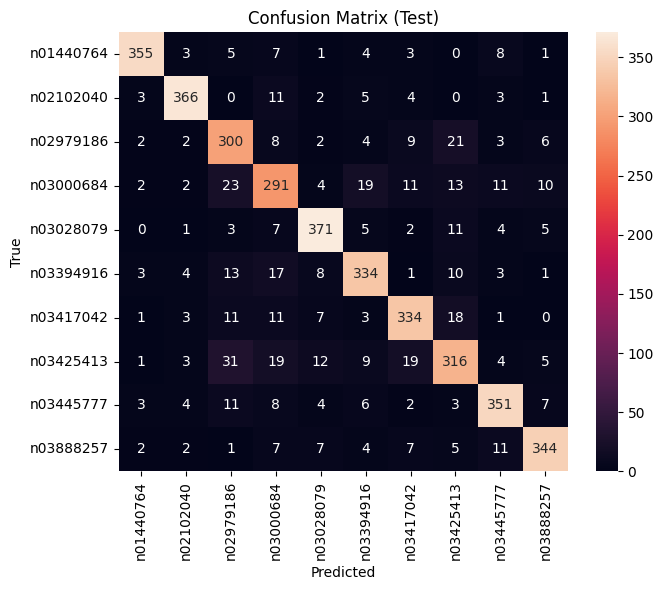

              precision    recall  f1-score   support

   n01440764     0.9543    0.9173    0.9354       387
   n02102040     0.9385    0.9266    0.9325       395
   n02979186     0.7538    0.8403    0.7947       357
   n03000684     0.7539    0.7539    0.7539       386
   n03028079     0.8876    0.9071    0.8972       409
   n03394916     0.8499    0.8477    0.8488       394
   n03417042     0.8520    0.8586    0.8553       389
   n03425413     0.7960    0.7542    0.7745       419
   n03445777     0.8797    0.8797    0.8797       399
   n03888257     0.9053    0.8821    0.8935       390

    accuracy                         0.8566      3925
   macro avg     0.8571    0.8567    0.8566      3925
weighted avg     0.8578    0.8566    0.8569      3925



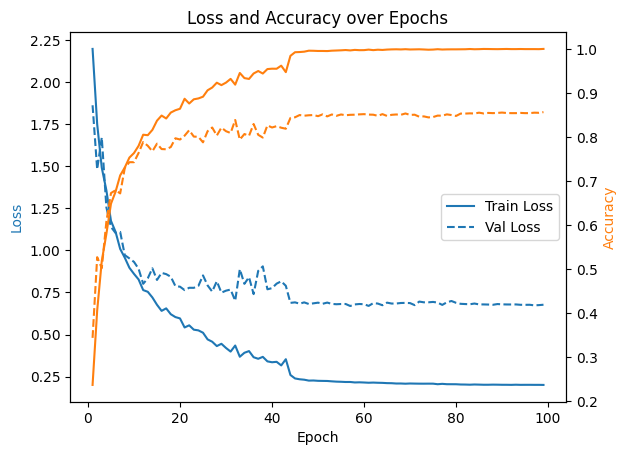

In [5]:
# ======================================================================
# Run InceptionV1 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = InceptionV1(num_classes=10, p_drop=0.4)

results = run_imagefolder_experiment(
    data_dir="../data/imagenette2",   # contains train/ and valid/
    model=model,
    img_size=224, resize_side=256, augment=True,
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=100, patience=25,
    monitor="acc", min_delta=0.0,
    lr_patience=10, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_inceptionv1_best.pth",
)

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Inspecting: ../data/imagenette2
[data] Found explicit splits.


[epoch 001 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 001] train: loss=1.7388, acc=0.4430 | val: loss=1.5417, acc=0.5585 | time: 21.75s
  [checkpoint] New best (acc=0.5585) saved -> imagenette2_inceptionv2_best.pth


[epoch 002 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 002] train: loss=1.2727, acc=0.6192 | val: loss=1.8975, acc=0.5001 | time: 21.23s
  [early-stop] No improvement (1/25) on acc; best=0.5585, current=0.5001


[epoch 003 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 003] train: loss=1.1694, acc=0.6566 | val: loss=1.6099, acc=0.5373 | time: 41.09s
  [early-stop] No improvement (2/25) on acc; best=0.5585, current=0.5373


[epoch 004 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 004] train: loss=1.0408, acc=0.7060 | val: loss=1.3469, acc=0.6206 | time: 21.23s
  [checkpoint] New best (acc=0.6206) saved -> imagenette2_inceptionv2_best.pth


[epoch 005 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 005] train: loss=0.9271, acc=0.7370 | val: loss=0.9045, acc=0.7478 | time: 21.23s
  [checkpoint] New best (acc=0.7478) saved -> imagenette2_inceptionv2_best.pth


[epoch 006 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 006] train: loss=0.8612, acc=0.7624 | val: loss=1.0122, acc=0.7215 | time: 21.33s
  [early-stop] No improvement (1/25) on acc; best=0.7478, current=0.7215


[epoch 007 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 007] train: loss=0.8110, acc=0.7803 | val: loss=0.8649, acc=0.7620 | time: 22.34s
  [checkpoint] New best (acc=0.7620) saved -> imagenette2_inceptionv2_best.pth


[epoch 008 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 008] train: loss=0.7535, acc=0.7966 | val: loss=0.8725, acc=0.7615 | time: 21.20s
  [early-stop] No improvement (1/25) on acc; best=0.7620, current=0.7615


[epoch 009 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 009] train: loss=0.7260, acc=0.8116 | val: loss=0.9051, acc=0.7575 | time: 21.38s
  [early-stop] No improvement (2/25) on acc; best=0.7620, current=0.7575


[epoch 010 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 010] train: loss=0.6884, acc=0.8234 | val: loss=0.9736, acc=0.7320 | time: 21.21s
  [early-stop] No improvement (3/25) on acc; best=0.7620, current=0.7320


[epoch 011 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 011] train: loss=0.6470, acc=0.8411 | val: loss=0.8007, acc=0.7936 | time: 61.56s
  [checkpoint] New best (acc=0.7936) saved -> imagenette2_inceptionv2_best.pth


[epoch 012 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 012] train: loss=0.6147, acc=0.8504 | val: loss=0.8007, acc=0.7890 | time: 41.17s
  [early-stop] No improvement (1/25) on acc; best=0.7936, current=0.7890


[epoch 013 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 013] train: loss=0.6003, acc=0.8554 | val: loss=0.8377, acc=0.7702 | time: 22.26s
  [early-stop] No improvement (2/25) on acc; best=0.7936, current=0.7702


[epoch 014 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 014] train: loss=0.5738, acc=0.8679 | val: loss=0.8084, acc=0.7906 | time: 21.80s
  [early-stop] No improvement (3/25) on acc; best=0.7936, current=0.7906


[epoch 015 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 015] train: loss=0.5609, acc=0.8716 | val: loss=0.6976, acc=0.8211 | time: 41.28s
  [checkpoint] New best (acc=0.8211) saved -> imagenette2_inceptionv2_best.pth


[epoch 016 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 016] train: loss=0.5371, acc=0.8779 | val: loss=0.7293, acc=0.8117 | time: 21.20s
  [early-stop] No improvement (1/25) on acc; best=0.8211, current=0.8117


[epoch 017 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 017] train: loss=0.5212, acc=0.8848 | val: loss=0.9022, acc=0.7625 | time: 21.61s
  [early-stop] No improvement (2/25) on acc; best=0.8211, current=0.7625


[epoch 018 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 018] train: loss=0.5111, acc=0.8825 | val: loss=0.8228, acc=0.7883 | time: 61.52s
  [early-stop] No improvement (3/25) on acc; best=0.8211, current=0.7883


[epoch 019 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 019] train: loss=0.4682, acc=0.9038 | val: loss=0.8876, acc=0.7580 | time: 21.61s
  [early-stop] No improvement (4/25) on acc; best=0.8211, current=0.7580


[epoch 020 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 020] train: loss=0.4660, acc=0.9008 | val: loss=0.7155, acc=0.8186 | time: 61.35s
  [early-stop] No improvement (5/25) on acc; best=0.8211, current=0.8186


[epoch 021 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 021] train: loss=0.4564, acc=0.9093 | val: loss=0.7029, acc=0.8234 | time: 21.30s
  [checkpoint] New best (acc=0.8234) saved -> imagenette2_inceptionv2_best.pth


[epoch 022 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 022] train: loss=0.4369, acc=0.9166 | val: loss=0.6977, acc=0.8265 | time: 41.35s
  [checkpoint] New best (acc=0.8265) saved -> imagenette2_inceptionv2_best.pth


[epoch 023 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 023] train: loss=0.4186, acc=0.9201 | val: loss=0.8192, acc=0.7946 | time: 21.37s
  [early-stop] No improvement (1/25) on acc; best=0.8265, current=0.7946


[epoch 024 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 024] train: loss=0.4251, acc=0.9204 | val: loss=0.7399, acc=0.8191 | time: 21.21s
  [early-stop] No improvement (2/25) on acc; best=0.8265, current=0.8191


[epoch 025 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 025] train: loss=0.4070, acc=0.9236 | val: loss=0.6654, acc=0.8448 | time: 21.41s
  [checkpoint] New best (acc=0.8448) saved -> imagenette2_inceptionv2_best.pth


[epoch 026 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


[epoch 026] train: loss=0.4062, acc=0.9261 | val: loss=0.7449, acc=0.8143 | time: 41.51s
  [early-stop] No improvement (1/25) on acc; best=0.8448, current=0.8143


[epoch 027 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 027] train: loss=0.3841, acc=0.9353 | val: loss=0.7227, acc=0.8189 | time: 21.44s
  [early-stop] No improvement (2/25) on acc; best=0.8448, current=0.8189


[epoch 028 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 028] train: loss=0.3678, acc=0.9404 | val: loss=0.6775, acc=0.8380 | time: 21.64s
  [early-stop] No improvement (3/25) on acc; best=0.8448, current=0.8380


[epoch 029 | train]:   0%|          | 0/148 [00:40<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 029] train: loss=0.3634, acc=0.9409 | val: loss=0.6643, acc=0.8410 | time: 61.52s
  [early-stop] No improvement (4/25) on acc; best=0.8448, current=0.8410


[epoch 030 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 030 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 030] train: loss=0.3625, acc=0.9421 | val: loss=0.7239, acc=0.8262 | time: 21.80s
  [early-stop] No improvement (5/25) on acc; best=0.8448, current=0.8262


[epoch 031 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 031 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 031] train: loss=0.3411, acc=0.9522 | val: loss=0.7359, acc=0.8265 | time: 61.86s
  [early-stop] No improvement (6/25) on acc; best=0.8448, current=0.8265


[epoch 032 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 032 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 032] train: loss=0.3542, acc=0.9467 | val: loss=0.6870, acc=0.8362 | time: 21.74s
  [early-stop] No improvement (7/25) on acc; best=0.8448, current=0.8362


[epoch 033 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 033 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 033] train: loss=0.3393, acc=0.9490 | val: loss=0.6744, acc=0.8403 | time: 41.89s
  [early-stop] No improvement (8/25) on acc; best=0.8448, current=0.8403


[epoch 034 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 034 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 034] train: loss=0.3310, acc=0.9524 | val: loss=0.7052, acc=0.8369 | time: 21.51s
  [early-stop] No improvement (9/25) on acc; best=0.8448, current=0.8369


[epoch 035 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 035 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 035] train: loss=0.3317, acc=0.9516 | val: loss=0.7505, acc=0.8252 | time: 21.82s
  [early-stop] No improvement (10/25) on acc; best=0.8448, current=0.8252


[epoch 036 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 036 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 036] train: loss=0.3274, acc=0.9546 | val: loss=0.6789, acc=0.8349 | time: 21.44s
Epoch 00036: reducing learning rate of group 0 to 3.0000e-05.
  [early-stop] No improvement (11/25) on acc; best=0.8448, current=0.8349


[epoch 037 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 037 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 037] train: loss=0.2620, acc=0.9799 | val: loss=0.5346, acc=0.8808 | time: 61.24s
  [checkpoint] New best (acc=0.8808) saved -> imagenette2_inceptionv2_best.pth


[epoch 038 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 038 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 038] train: loss=0.2393, acc=0.9887 | val: loss=0.5263, acc=0.8797 | time: 21.01s
  [early-stop] No improvement (1/25) on acc; best=0.8808, current=0.8797


[epoch 039 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 039 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 039] train: loss=0.2293, acc=0.9927 | val: loss=0.5271, acc=0.8815 | time: 21.19s
  [checkpoint] New best (acc=0.8815) saved -> imagenette2_inceptionv2_best.pth


[epoch 040 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 040 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 040] train: loss=0.2295, acc=0.9916 | val: loss=0.5306, acc=0.8787 | time: 21.31s
  [early-stop] No improvement (1/25) on acc; best=0.8815, current=0.8787


[epoch 041 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 041 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 041] train: loss=0.2222, acc=0.9943 | val: loss=0.5336, acc=0.8810 | time: 41.22s
  [early-stop] No improvement (2/25) on acc; best=0.8815, current=0.8810


[epoch 042 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 042 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 042] train: loss=0.2199, acc=0.9946 | val: loss=0.5260, acc=0.8828 | time: 21.12s
  [checkpoint] New best (acc=0.8828) saved -> imagenette2_inceptionv2_best.pth


[epoch 043 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 043 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 043] train: loss=0.2180, acc=0.9954 | val: loss=0.5231, acc=0.8854 | time: 21.36s
  [checkpoint] New best (acc=0.8854) saved -> imagenette2_inceptionv2_best.pth


[epoch 044 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 044 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 044] train: loss=0.2164, acc=0.9961 | val: loss=0.5199, acc=0.8869 | time: 21.49s
  [checkpoint] New best (acc=0.8869) saved -> imagenette2_inceptionv2_best.pth


[epoch 045 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 045 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 045] train: loss=0.2143, acc=0.9966 | val: loss=0.5201, acc=0.8882 | time: 21.65s
  [checkpoint] New best (acc=0.8882) saved -> imagenette2_inceptionv2_best.pth


[epoch 046 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 046 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 046] train: loss=0.2125, acc=0.9968 | val: loss=0.5234, acc=0.8887 | time: 41.82s
  [checkpoint] New best (acc=0.8887) saved -> imagenette2_inceptionv2_best.pth


[epoch 047 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 047 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 047] train: loss=0.2144, acc=0.9955 | val: loss=0.5225, acc=0.8882 | time: 21.87s
  [early-stop] No improvement (1/25) on acc; best=0.8887, current=0.8882


[epoch 048 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 048 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 048] train: loss=0.2117, acc=0.9963 | val: loss=0.5178, acc=0.8876 | time: 21.59s
  [early-stop] No improvement (2/25) on acc; best=0.8887, current=0.8876


[epoch 049 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 049 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 049] train: loss=0.2098, acc=0.9975 | val: loss=0.5246, acc=0.8884 | time: 21.38s
  [early-stop] No improvement (3/25) on acc; best=0.8887, current=0.8884


[epoch 050 | train]:   0%|          | 0/148 [00:20<?, ?it/s]

[epoch 050 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 050] train: loss=0.2085, acc=0.9974 | val: loss=0.5262, acc=0.8876 | time: 41.81s
  [early-stop] No improvement (4/25) on acc; best=0.8887, current=0.8876


[epoch 051 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 051 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 051] train: loss=0.2080, acc=0.9976 | val: loss=0.5189, acc=0.8871 | time: 21.63s
  [early-stop] No improvement (5/25) on acc; best=0.8887, current=0.8871


[epoch 052 | train]:   0%|          | 0/148 [00:20<?, ?it/s]

[epoch 052 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 052] train: loss=0.2078, acc=0.9975 | val: loss=0.5241, acc=0.8894 | time: 41.54s
  [checkpoint] New best (acc=0.8894) saved -> imagenette2_inceptionv2_best.pth


[epoch 053 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 053 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 053] train: loss=0.2065, acc=0.9985 | val: loss=0.5132, acc=0.8920 | time: 21.57s
  [checkpoint] New best (acc=0.8920) saved -> imagenette2_inceptionv2_best.pth


[epoch 054 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 054 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 054] train: loss=0.2054, acc=0.9984 | val: loss=0.5198, acc=0.8854 | time: 21.69s
  [early-stop] No improvement (1/25) on acc; best=0.8920, current=0.8854


[epoch 055 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 055 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 055] train: loss=0.2052, acc=0.9982 | val: loss=0.5248, acc=0.8897 | time: 21.46s
  [early-stop] No improvement (2/25) on acc; best=0.8920, current=0.8897


[epoch 056 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 056 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 056] train: loss=0.2049, acc=0.9981 | val: loss=0.5255, acc=0.8874 | time: 61.74s
  [early-stop] No improvement (3/25) on acc; best=0.8920, current=0.8874


[epoch 057 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 057 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 057] train: loss=0.2044, acc=0.9982 | val: loss=0.5337, acc=0.8864 | time: 21.58s
  [early-stop] No improvement (4/25) on acc; best=0.8920, current=0.8864


[epoch 058 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 058 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 058] train: loss=0.2054, acc=0.9979 | val: loss=0.5216, acc=0.8884 | time: 81.55s
  [early-stop] No improvement (5/25) on acc; best=0.8920, current=0.8884


[epoch 059 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 059 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 059] train: loss=0.2051, acc=0.9974 | val: loss=0.5242, acc=0.8904 | time: 21.92s
  [early-stop] No improvement (6/25) on acc; best=0.8920, current=0.8904


[epoch 060 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 060 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 060] train: loss=0.2026, acc=0.9980 | val: loss=0.5201, acc=0.8897 | time: 21.74s
  [early-stop] No improvement (7/25) on acc; best=0.8920, current=0.8897


[epoch 061 | train]:   0%|          | 0/148 [00:20<?, ?it/s]

[epoch 061 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 061] train: loss=0.2021, acc=0.9982 | val: loss=0.5279, acc=0.8876 | time: 41.96s
  [early-stop] No improvement (8/25) on acc; best=0.8920, current=0.8876


[epoch 062 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 062 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 062] train: loss=0.2025, acc=0.9981 | val: loss=0.5276, acc=0.8894 | time: 21.41s
  [early-stop] No improvement (9/25) on acc; best=0.8920, current=0.8894


[epoch 063 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 063 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 063] train: loss=0.2019, acc=0.9986 | val: loss=0.5319, acc=0.8825 | time: 41.18s
  [early-stop] No improvement (10/25) on acc; best=0.8920, current=0.8825


[epoch 064 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 064 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 064] train: loss=0.1994, acc=0.9992 | val: loss=0.5310, acc=0.8859 | time: 21.02s
Epoch 00064: reducing learning rate of group 0 to 3.0000e-06.
  [early-stop] No improvement (11/25) on acc; best=0.8920, current=0.8859


[epoch 065 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 065 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 065] train: loss=0.1987, acc=0.9989 | val: loss=0.5239, acc=0.8871 | time: 60.98s
  [early-stop] No improvement (12/25) on acc; best=0.8920, current=0.8871


[epoch 066 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 066 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 066] train: loss=0.1987, acc=0.9989 | val: loss=0.5191, acc=0.8892 | time: 20.74s
  [early-stop] No improvement (13/25) on acc; best=0.8920, current=0.8892


[epoch 067 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 067 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 067] train: loss=0.1994, acc=0.9989 | val: loss=0.5188, acc=0.8892 | time: 20.96s
  [early-stop] No improvement (14/25) on acc; best=0.8920, current=0.8892


[epoch 068 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 068 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 068] train: loss=0.1988, acc=0.9992 | val: loss=0.5152, acc=0.8889 | time: 20.85s
  [early-stop] No improvement (15/25) on acc; best=0.8920, current=0.8889


[epoch 069 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 069 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 069] train: loss=0.1980, acc=0.9993 | val: loss=0.5183, acc=0.8876 | time: 81.79s
  [early-stop] No improvement (16/25) on acc; best=0.8920, current=0.8876


[epoch 070 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 070 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 070] train: loss=0.1983, acc=0.9992 | val: loss=0.5205, acc=0.8871 | time: 21.75s
  [early-stop] No improvement (17/25) on acc; best=0.8920, current=0.8871


[epoch 071 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 071 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 071] train: loss=0.1979, acc=0.9995 | val: loss=0.5188, acc=0.8887 | time: 21.50s
  [early-stop] No improvement (18/25) on acc; best=0.8920, current=0.8887


[epoch 072 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 072 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 072] train: loss=0.1977, acc=0.9994 | val: loss=0.5161, acc=0.8904 | time: 61.77s
  [early-stop] No improvement (19/25) on acc; best=0.8920, current=0.8904


[epoch 073 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 073 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 073] train: loss=0.1978, acc=0.9992 | val: loss=0.5147, acc=0.8894 | time: 21.58s
  [early-stop] No improvement (20/25) on acc; best=0.8920, current=0.8894


[epoch 074 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 074 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 074] train: loss=0.1976, acc=0.9993 | val: loss=0.5142, acc=0.8899 | time: 41.46s
  [early-stop] No improvement (21/25) on acc; best=0.8920, current=0.8899


[epoch 075 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 075 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 075] train: loss=0.1971, acc=0.9993 | val: loss=0.5153, acc=0.8904 | time: 21.78s
  [early-stop] No improvement (22/25) on acc; best=0.8920, current=0.8904


[epoch 076 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 076 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 076] train: loss=0.1972, acc=0.9994 | val: loss=0.5162, acc=0.8884 | time: 21.40s
Epoch 00076: reducing learning rate of group 0 to 1.0000e-06.
  [early-stop] No improvement (23/25) on acc; best=0.8920, current=0.8884


[epoch 077 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 077 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 077] train: loss=0.1970, acc=0.9994 | val: loss=0.5098, acc=0.8907 | time: 21.32s
  [early-stop] No improvement (24/25) on acc; best=0.8920, current=0.8907


[epoch 078 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 078 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 078] train: loss=0.1960, acc=0.9999 | val: loss=0.5131, acc=0.8910 | time: 81.91s
  [early-stop] No improvement (25/25) on acc; best=0.8920, current=0.8910
  [early-stop] Patience exceeded — stopping.


[test]:   0%|          | 0/62 [00:00<?, ?it/s]

[eval] Test accuracy: 0.8920


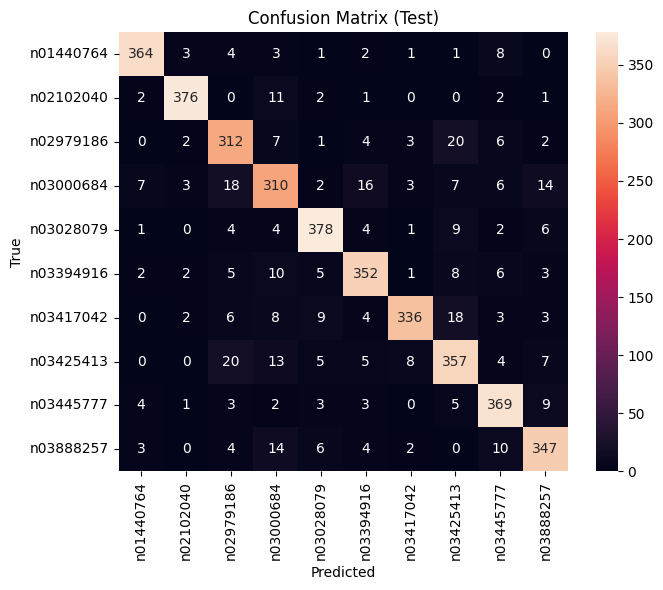

              precision    recall  f1-score   support

   n01440764     0.9504    0.9406    0.9455       387
   n02102040     0.9666    0.9519    0.9592       395
   n02979186     0.8298    0.8739    0.8513       357
   n03000684     0.8115    0.8031    0.8073       386
   n03028079     0.9175    0.9242    0.9208       409
   n03394916     0.8911    0.8934    0.8923       394
   n03417042     0.9465    0.8638    0.9032       389
   n03425413     0.8400    0.8520    0.8460       419
   n03445777     0.8870    0.9248    0.9055       399
   n03888257     0.8852    0.8897    0.8875       390

    accuracy                         0.8920      3925
   macro avg     0.8926    0.8917    0.8919      3925
weighted avg     0.8929    0.8920    0.8922      3925



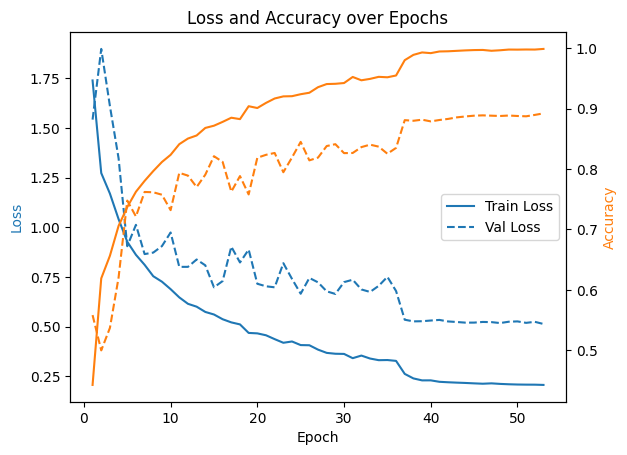

In [11]:
# ======================================================================
# Run InceptionV2 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = InceptionV2(num_classes=10, p_drop=0.4)

results_v2 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",
    model=model,
    img_size=224, resize_side=256, augment=True,
    batch_train=64, batch_eval=64,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=25,
    monitor="acc", min_delta=0.0,
    lr_patience=10, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_inceptionv2_best.pth",
)

In [4]:
# ======================================================================
# Inception v3 — from scratch (PyTorch), for 299x299 RGB
#  - Factorized convolutions:
#      • 7x7 → (1x7) + (7x1)
#      • 3x3 → (1x3) + (3x1)
#  - BatchNorm after every conv
#  - Optional auxiliary classifier at 17x17 stage (aux_logits=True)
#  - He initialization for conv/linear, BN gamma=1, beta=0
#  - AdaptiveAvgPool → Dropout → Fully Connected (final logits)
#  - Returns (main_logits, aux_logits) during training if aux enabled; else just logits
# ======================================================================

import torch
import torch.nn as nn

# ------------------------ Conv-BN-ReLU ------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.ones_(self.bn.weight)
        nn.init.zeros_(self.bn.bias)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


# ------------------------ Inception-A (35x35) ------------------------
class InceptionA(nn.Module):
    def __init__(self, in_ch, pool_proj):
        super().__init__()
        # 1x1
        self.branch1x1 = ConvBNReLU(in_ch, 64, kernel_size=1)

        # 5x5 path: 1x1 → 5x5
        self.branch5x5 = nn.Sequential(
            ConvBNReLU(in_ch, 48, kernel_size=1),
            ConvBNReLU(48, 64, kernel_size=5, padding=2)
        )

        # double 3x3: 1x1 → 3x3 → 3x3
        self.branch3x3dbl = nn.Sequential(
            ConvBNReLU(in_ch, 64, kernel_size=1),
            ConvBNReLU(64, 96, kernel_size=3, padding=1),
            ConvBNReLU(96, 96, kernel_size=3, padding=1)
        )

        # avg pool → 1x1 projection
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_ch, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch5x5(x)
        b3 = self.branch3x3dbl(x)
        b4 = self.branch_pool(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


# ------------------------ Inception-B (17x17) ------------------------
class InceptionB(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        # 1x1
        self.branch1x1 = ConvBNReLU(in_ch, 192, kernel_size=1)

        # 7x7 factorized: 1x1 → (1x7) → (7x1)
        self.branch7x7 = nn.Sequential(
            ConvBNReLU(in_ch, 128, kernel_size=1),
            ConvBNReLU(128, 128, kernel_size=(1,7), padding=(0,3)),
            ConvBNReLU(128, 192, kernel_size=(7,1), padding=(3,0))
        )

        # double 7x7 factorized
        self.branch7x7dbl = nn.Sequential(
            ConvBNReLU(in_ch, 128, kernel_size=1),
            ConvBNReLU(128, 128, kernel_size=(7,1), padding=(3,0)),
            ConvBNReLU(128, 128, kernel_size=(1,7), padding=(0,3)),
            ConvBNReLU(128, 128, kernel_size=(7,1), padding=(3,0)),
            ConvBNReLU(128, 192, kernel_size=(1,7), padding=(0,3))
        )

        # avg pool → 1x1
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_ch, 192, kernel_size=1)
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch7x7(x)
        b3 = self.branch7x7dbl(x)
        b4 = self.branch_pool(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


# ------------------------ Inception-C (8x8) ------------------------
class InceptionC(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        # 1x1
        self.branch1x1 = ConvBNReLU(in_ch, 320, kernel_size=1)

        # 3x3 split into (1x3) and (3x1)
        self.branch3x3 = ConvBNReLU(in_ch, 384, kernel_size=1)
        self.branch3x3_1 = ConvBNReLU(384, 384, kernel_size=(1,3), padding=(0,1))
        self.branch3x3_2 = ConvBNReLU(384, 384, kernel_size=(3,1), padding=(1,0))

        # double 3x3 path then split
        self.branch3x3dbl = nn.Sequential(
            ConvBNReLU(in_ch, 448, kernel_size=1),
            ConvBNReLU(448, 384, kernel_size=3, padding=1)
        )
        self.branch3x3dbl_1 = ConvBNReLU(384, 384, kernel_size=(1,3), padding=(0,1))
        self.branch3x3dbl_2 = ConvBNReLU(384, 384, kernel_size=(3,1), padding=(1,0))

        # avg pool → 1x1
        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_ch, 192, kernel_size=1)
        )

    def forward(self, x):
        b1 = self.branch1x1(x)

        b2 = self.branch3x3(x)
        b2 = torch.cat([self.branch3x3_1(b2), self.branch3x3_2(b2)], dim=1)

        b3 = self.branch3x3dbl(x)
        b3 = torch.cat([self.branch3x3dbl_1(b3), self.branch3x3dbl_2(b3)], dim=1)

        b4 = self.branch_pool(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


# ------------------------ Reduction-A (35→17) ------------------------
class ReductionA(nn.Module):
    # k,l,m,n are channel hyperparams used in the original paper/config
    def __init__(self, in_ch, k, l, m, n):
        super().__init__()
        self.branch3x3 = ConvBNReLU(in_ch, n, kernel_size=3, stride=2)

        self.branch3x3dbl = nn.Sequential(
            ConvBNReLU(in_ch, k, kernel_size=1),
            ConvBNReLU(k, l, kernel_size=3, padding=1),
            ConvBNReLU(l, m, kernel_size=3, stride=2)
        )

        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        b1 = self.branch3x3(x)
        b2 = self.branch3x3dbl(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)


# ------------------------ Reduction-B (17→8) ------------------------
class ReductionB(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            ConvBNReLU(in_ch, 192, kernel_size=1),
            ConvBNReLU(192, 320, kernel_size=3, stride=2)
        )
        self.branch7x7x3 = nn.Sequential(
            ConvBNReLU(in_ch, 192, kernel_size=1),
            ConvBNReLU(192, 192, kernel_size=(1,7), padding=(0,3)),
            ConvBNReLU(192, 192, kernel_size=(7,1), padding=(3,0)),
            ConvBNReLU(192, 192, kernel_size=3, stride=2)
        )
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        b1 = self.branch3x3(x)
        b2 = self.branch7x7x3(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)


# ------------------------ Auxiliary Classifier (optional) ------------------------
class InceptionAux(nn.Module):
    # Input feature map is 17x17 with 768 channels
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),  # 17x17 -> 5x5
            ConvBNReLU(in_ch, 128, kernel_size=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, 768),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(768, num_classes)
        )
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


# ------------------------ Inception v3 (full) ------------------------
class InceptionV3(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits

        # Stem (299 -> 35)
        self.Conv1   = ConvBNReLU(3, 32, kernel_size=3, stride=2)        # 299 -> 149
        self.Conv2   = ConvBNReLU(32, 32, kernel_size=3)                 # 149 -> 147
        self.Conv3   = ConvBNReLU(32, 64, kernel_size=3, padding=1)      # 147 -> 147
        self.MaxPool1= nn.MaxPool2d(kernel_size=3, stride=2)             # 147 -> 73
        self.Conv4   = ConvBNReLU(64, 80, kernel_size=1)
        self.Conv5   = ConvBNReLU(80, 192, kernel_size=3)                # 73 -> 71
        self.MaxPool2= nn.MaxPool2d(kernel_size=3, stride=2)             # 71 -> 35

        # 35x35 Inception-A ×3
        self.inception_a = nn.Sequential(
            InceptionA(192, pool_proj=32),   # out: 64+64+96+32 = 256
            InceptionA(256, pool_proj=64),   # out: 64+64+96+64 = 288
            InceptionA(288, pool_proj=64)    # out: 64+64+96+64 = 288
        )

        # Reduction-A: 35 -> 17
        self.reduction_a = ReductionA(288, k=64, l=96, m=96, n=384)      # out: 384+96 + 288? (concat) = 768

        # 17x17 Inception-B ×4
        self.inception_b = nn.Sequential(
            InceptionB(768),
            InceptionB(768),
            InceptionB(768),
            InceptionB(768)
        )

        # Optional auxiliary classifier at 17x17 stage
        if aux_logits:
            self.aux = InceptionAux(768, num_classes)

        # Reduction-B: 17 -> 8
        self.reduction_b = ReductionB(768)                                # out: 320 + 192 + 768? (pooled) = 1280

        # 8x8 Inception-C ×3
        self.inception_c = nn.Sequential(
            InceptionC(1280),
            InceptionC(2048),
            InceptionC(2048)
        )

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc      = nn.Linear(2048, num_classes)
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # Stem
        x = self.Conv1(x);  x = self.Conv2(x);  x = self.Conv3(x)
        x = self.MaxPool1(x)
        x = self.Conv4(x);  x = self.Conv5(x)
        x = self.MaxPool2(x)

        # 35x35 → Inception-A stack → Reduction-A
        x = self.inception_a(x)
        x = self.reduction_a(x)

        # 17x17 → Inception-B stack (+ aux during training)
        x = self.inception_b(x)
        aux_out = None
        if self.aux_logits and self.training:
            aux_out = self.aux(x)

        # 8x8 → Reduction-B → Inception-C stack
        x = self.reduction_b(x)
        x = self.inception_c(x)

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training:
            return x, aux_out
        return x

In [ ]:
# ======================================================================
# Run InceptionV3 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = InceptionV3(num_classes=10, aux_logits=True)  # enable aux head

results_v3 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",   # contains train/ and valid/ folders
    model=model,
    img_size=299, resize_side=320, augment=True,  # v3 uses 299x299 input
    batch_train=32, batch_eval=64,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=25,
    monitor="acc", min_delta=0.0,
    lr_patience=10, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_inceptionv3_best.pth",
    use_aux=True,
    use_amp=True
)

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Inspecting: ../data/imagenette2
[data] Found explicit splits.


[epoch 001 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 001] train: loss=2.5837, acc=0.4132 | val: loss=1.5390, acc=0.5511 | time: 28.04s
  [checkpoint] New best (acc=0.5511) saved -> imagenette2_inceptionv3_best.pth


[epoch 002 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 002] train: loss=1.8686, acc=0.5928 | val: loss=1.5616, acc=0.5544 | time: 28.24s
  [checkpoint] New best (acc=0.5544) saved -> imagenette2_inceptionv3_best.pth


[epoch 003 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 003] train: loss=1.5865, acc=0.6623 | val: loss=1.3796, acc=0.6069 | time: 28.05s
  [checkpoint] New best (acc=0.6069) saved -> imagenette2_inceptionv3_best.pth


[epoch 004 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 004] train: loss=1.3827, acc=0.7198 | val: loss=1.1201, acc=0.6859 | time: 28.04s
  [checkpoint] New best (acc=0.6859) saved -> imagenette2_inceptionv3_best.pth


[epoch 005 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 005] train: loss=1.2775, acc=0.7489 | val: loss=0.8917, acc=0.7569 | time: 27.89s
  [checkpoint] New best (acc=0.7569) saved -> imagenette2_inceptionv3_best.pth


[epoch 006 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 006] train: loss=1.1943, acc=0.7667 | val: loss=1.0205, acc=0.7088 | time: 28.34s
  [early-stop] No improvement (1/25) on acc; best=0.7569, current=0.7088


[epoch 007 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 007] train: loss=1.1095, acc=0.7913 | val: loss=0.9157, acc=0.7587 | time: 27.82s
  [checkpoint] New best (acc=0.7587) saved -> imagenette2_inceptionv3_best.pth


[epoch 008 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 008] train: loss=1.0544, acc=0.8046 | val: loss=0.8244, acc=0.7712 | time: 27.80s
  [checkpoint] New best (acc=0.7712) saved -> imagenette2_inceptionv3_best.pth


[epoch 009 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 009] train: loss=0.9976, acc=0.8167 | val: loss=0.8815, acc=0.7730 | time: 328.46s
  [checkpoint] New best (acc=0.7730) saved -> imagenette2_inceptionv3_best.pth


[epoch 010 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 010] train: loss=0.9372, acc=0.8325 | val: loss=0.8278, acc=0.7781 | time: 27.60s
  [checkpoint] New best (acc=0.7781) saved -> imagenette2_inceptionv3_best.pth


[epoch 011 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 011] train: loss=0.8858, acc=0.8457 | val: loss=0.8106, acc=0.7977 | time: 27.88s
  [checkpoint] New best (acc=0.7977) saved -> imagenette2_inceptionv3_best.pth


[epoch 012 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 012] train: loss=0.8404, acc=0.8553 | val: loss=0.9116, acc=0.7679 | time: 28.66s
  [early-stop] No improvement (1/25) on acc; best=0.7977, current=0.7679


[epoch 013 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 013] train: loss=0.7998, acc=0.8694 | val: loss=0.8479, acc=0.7860 | time: 27.84s
  [early-stop] No improvement (2/25) on acc; best=0.7977, current=0.7860


[epoch 014 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 014] train: loss=0.7728, acc=0.8750 | val: loss=0.7570, acc=0.8074 | time: 28.55s
  [checkpoint] New best (acc=0.8074) saved -> imagenette2_inceptionv3_best.pth


[epoch 015 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 015] train: loss=0.7581, acc=0.8795 | val: loss=0.7501, acc=0.8155 | time: 27.67s
  [checkpoint] New best (acc=0.8155) saved -> imagenette2_inceptionv3_best.pth


[epoch 016 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 016] train: loss=0.7095, acc=0.8913 | val: loss=0.7748, acc=0.8059 | time: 27.75s
  [early-stop] No improvement (1/25) on acc; best=0.8155, current=0.8059


[epoch 017 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 017] train: loss=0.6914, acc=0.8952 | val: loss=0.6799, acc=0.8369 | time: 28.09s
  [checkpoint] New best (acc=0.8369) saved -> imagenette2_inceptionv3_best.pth


[epoch 018 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 018] train: loss=0.6635, acc=0.9038 | val: loss=0.7494, acc=0.8161 | time: 27.95s
  [early-stop] No improvement (1/25) on acc; best=0.8369, current=0.8161


[epoch 019 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 019] train: loss=0.6355, acc=0.9122 | val: loss=0.6611, acc=0.8443 | time: 27.86s
  [checkpoint] New best (acc=0.8443) saved -> imagenette2_inceptionv3_best.pth


[epoch 020 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 020] train: loss=0.6100, acc=0.9163 | val: loss=0.7836, acc=0.8087 | time: 27.81s
  [early-stop] No improvement (1/25) on acc; best=0.8443, current=0.8087


[epoch 021 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 021] train: loss=0.6058, acc=0.9170 | val: loss=0.7071, acc=0.8313 | time: 27.89s
  [early-stop] No improvement (2/25) on acc; best=0.8443, current=0.8313


[epoch 022 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 022] train: loss=0.5656, acc=0.9284 | val: loss=0.6875, acc=0.8400 | time: 28.22s
  [early-stop] No improvement (3/25) on acc; best=0.8443, current=0.8400


[epoch 023 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 023] train: loss=0.5692, acc=0.9282 | val: loss=0.6632, acc=0.8469 | time: 27.99s
  [checkpoint] New best (acc=0.8469) saved -> imagenette2_inceptionv3_best.pth


[epoch 024 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 024] train: loss=0.5398, acc=0.9355 | val: loss=0.6536, acc=0.8487 | time: 28.23s
  [checkpoint] New best (acc=0.8487) saved -> imagenette2_inceptionv3_best.pth


[epoch 025 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 025] train: loss=0.5270, acc=0.9379 | val: loss=0.6785, acc=0.8400 | time: 27.90s
  [early-stop] No improvement (1/25) on acc; best=0.8487, current=0.8400


[epoch 026 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 026] train: loss=0.5065, acc=0.9435 | val: loss=0.7129, acc=0.8385 | time: 28.18s
  [early-stop] No improvement (2/25) on acc; best=0.8487, current=0.8385


[epoch 027 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 027] train: loss=0.5170, acc=0.9390 | val: loss=0.6844, acc=0.8380 | time: 27.53s
  [early-stop] No improvement (3/25) on acc; best=0.8487, current=0.8380


[epoch 028 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 028] train: loss=0.4850, acc=0.9500 | val: loss=0.6594, acc=0.8545 | time: 28.66s
  [checkpoint] New best (acc=0.8545) saved -> imagenette2_inceptionv3_best.pth


[epoch 029 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 029] train: loss=0.4672, acc=0.9544 | val: loss=0.7069, acc=0.8362 | time: 29.11s
  [early-stop] No improvement (1/25) on acc; best=0.8545, current=0.8362


[epoch 030 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 030 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 030] train: loss=0.4626, acc=0.9541 | val: loss=0.7284, acc=0.8415 | time: 29.14s
  [early-stop] No improvement (2/25) on acc; best=0.8545, current=0.8415


[epoch 031 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 031 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 031] train: loss=0.4564, acc=0.9565 | val: loss=0.6593, acc=0.8484 | time: 30.13s
  [early-stop] No improvement (3/25) on acc; best=0.8545, current=0.8484


[epoch 032 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 032 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 032] train: loss=0.4603, acc=0.9524 | val: loss=0.6590, acc=0.8520 | time: 48.60s
  [early-stop] No improvement (4/25) on acc; best=0.8545, current=0.8520


[epoch 033 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 033 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 033] train: loss=0.4435, acc=0.9598 | val: loss=0.8494, acc=0.8033 | time: 27.63s
  [early-stop] No improvement (5/25) on acc; best=0.8545, current=0.8033


[epoch 034 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 034 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 034] train: loss=0.4194, acc=0.9627 | val: loss=0.6532, acc=0.8540 | time: 27.66s
  [early-stop] No improvement (6/25) on acc; best=0.8545, current=0.8540


[epoch 035 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 035 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 035] train: loss=0.4250, acc=0.9654 | val: loss=0.6445, acc=0.8589 | time: 27.88s
  [checkpoint] New best (acc=0.8589) saved -> imagenette2_inceptionv3_best.pth


[epoch 036 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 036 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 036] train: loss=0.4335, acc=0.9606 | val: loss=0.6319, acc=0.8578 | time: 27.63s
  [early-stop] No improvement (1/25) on acc; best=0.8589, current=0.8578


[epoch 037 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 037 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 037] train: loss=0.4305, acc=0.9635 | val: loss=0.6371, acc=0.8581 | time: 27.28s
  [early-stop] No improvement (2/25) on acc; best=0.8589, current=0.8581


[epoch 038 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 038 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 038] train: loss=0.3973, acc=0.9713 | val: loss=0.6247, acc=0.8614 | time: 27.77s
  [checkpoint] New best (acc=0.8614) saved -> imagenette2_inceptionv3_best.pth


[epoch 039 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 039 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 039] train: loss=0.4027, acc=0.9701 | val: loss=0.6726, acc=0.8459 | time: 27.92s
  [early-stop] No improvement (1/25) on acc; best=0.8614, current=0.8459


[epoch 040 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 040 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 040] train: loss=0.4047, acc=0.9690 | val: loss=0.7869, acc=0.8250 | time: 28.07s
  [early-stop] No improvement (2/25) on acc; best=0.8614, current=0.8250


[epoch 041 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 041 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 041] train: loss=0.4007, acc=0.9687 | val: loss=0.6408, acc=0.8632 | time: 27.87s
  [checkpoint] New best (acc=0.8632) saved -> imagenette2_inceptionv3_best.pth


[epoch 042 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 042 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 042] train: loss=0.3980, acc=0.9687 | val: loss=0.6177, acc=0.8652 | time: 28.32s
  [checkpoint] New best (acc=0.8652) saved -> imagenette2_inceptionv3_best.pth


[epoch 043 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 043 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 043] train: loss=0.3851, acc=0.9721 | val: loss=0.6124, acc=0.8670 | time: 28.20s
  [checkpoint] New best (acc=0.8670) saved -> imagenette2_inceptionv3_best.pth


[epoch 044 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 044 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 044] train: loss=0.3872, acc=0.9728 | val: loss=0.6159, acc=0.8639 | time: 27.81s
  [early-stop] No improvement (1/25) on acc; best=0.8670, current=0.8639


[epoch 045 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 045 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 045] train: loss=0.3768, acc=0.9730 | val: loss=0.6151, acc=0.8759 | time: 27.59s
  [checkpoint] New best (acc=0.8759) saved -> imagenette2_inceptionv3_best.pth


[epoch 046 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 046 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 046] train: loss=0.3683, acc=0.9764 | val: loss=0.6325, acc=0.8619 | time: 27.53s
  [early-stop] No improvement (1/25) on acc; best=0.8759, current=0.8619


[epoch 047 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 047 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 047] train: loss=0.3764, acc=0.9752 | val: loss=0.6130, acc=0.8744 | time: 28.14s
  [early-stop] No improvement (2/25) on acc; best=0.8759, current=0.8744


[epoch 048 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 048 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 048] train: loss=0.3739, acc=0.9761 | val: loss=0.6122, acc=0.8698 | time: 27.99s
  [early-stop] No improvement (3/25) on acc; best=0.8759, current=0.8698


[epoch 049 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 049 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 049] train: loss=0.3768, acc=0.9748 | val: loss=0.5922, acc=0.8683 | time: 28.12s
  [early-stop] No improvement (4/25) on acc; best=0.8759, current=0.8683


[epoch 050 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 050 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 050] train: loss=0.3679, acc=0.9764 | val: loss=0.5819, acc=0.8746 | time: 27.77s
  [early-stop] No improvement (5/25) on acc; best=0.8759, current=0.8746


[epoch 051 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 051 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 051] train: loss=0.3570, acc=0.9791 | val: loss=0.6068, acc=0.8675 | time: 27.61s
  [early-stop] No improvement (6/25) on acc; best=0.8759, current=0.8675


[epoch 052 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 052 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 052] train: loss=0.3655, acc=0.9767 | val: loss=0.6449, acc=0.8589 | time: 28.21s
  [early-stop] No improvement (7/25) on acc; best=0.8759, current=0.8589


[epoch 053 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 053 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 053] train: loss=0.3665, acc=0.9772 | val: loss=0.5750, acc=0.8762 | time: 27.99s
  [checkpoint] New best (acc=0.8762) saved -> imagenette2_inceptionv3_best.pth


[epoch 054 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 054 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 054] train: loss=0.3613, acc=0.9773 | val: loss=0.6780, acc=0.8494 | time: 27.97s
  [early-stop] No improvement (1/25) on acc; best=0.8762, current=0.8494


[epoch 055 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 055 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 055] train: loss=0.3509, acc=0.9811 | val: loss=0.5873, acc=0.8708 | time: 28.47s
  [early-stop] No improvement (2/25) on acc; best=0.8762, current=0.8708


[epoch 056 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 056 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 056] train: loss=0.3452, acc=0.9823 | val: loss=0.7007, acc=0.8484 | time: 29.35s
  [early-stop] No improvement (3/25) on acc; best=0.8762, current=0.8484


[epoch 057 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out


[epoch 057 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 057] train: loss=0.3541, acc=0.9786 | val: loss=0.6253, acc=0.8698 | time: 47.93s
  [early-stop] No improvement (4/25) on acc; best=0.8762, current=0.8698


[epoch 058 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 058 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 058] train: loss=0.3583, acc=0.9770 | val: loss=0.5975, acc=0.8752 | time: 28.12s
  [early-stop] No improvement (5/25) on acc; best=0.8762, current=0.8752


[epoch 059 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 059 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 059] train: loss=0.3503, acc=0.9795 | val: loss=0.5797, acc=0.8764 | time: 27.83s
  [checkpoint] New best (acc=0.8764) saved -> imagenette2_inceptionv3_best.pth


[epoch 060 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 060 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 060] train: loss=0.3339, acc=0.9845 | val: loss=0.6289, acc=0.8713 | time: 27.77s
  [early-stop] No improvement (1/25) on acc; best=0.8764, current=0.8713


[epoch 061 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 061 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 061] train: loss=0.3391, acc=0.9834 | val: loss=0.6112, acc=0.8729 | time: 28.12s
  [early-stop] No improvement (2/25) on acc; best=0.8764, current=0.8729


[epoch 062 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 062 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 062] train: loss=0.3481, acc=0.9804 | val: loss=0.6047, acc=0.8726 | time: 27.50s
  [early-stop] No improvement (3/25) on acc; best=0.8764, current=0.8726


[epoch 063 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 063 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 063] train: loss=0.3317, acc=0.9858 | val: loss=0.5457, acc=0.8841 | time: 27.97s
  [checkpoint] New best (acc=0.8841) saved -> imagenette2_inceptionv3_best.pth


[epoch 064 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 064 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 064] train: loss=0.3328, acc=0.9852 | val: loss=0.5548, acc=0.8854 | time: 28.37s
  [checkpoint] New best (acc=0.8854) saved -> imagenette2_inceptionv3_best.pth


[epoch 065 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 065 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 065] train: loss=0.3339, acc=0.9848 | val: loss=0.6141, acc=0.8818 | time: 28.64s
  [early-stop] No improvement (1/25) on acc; best=0.8854, current=0.8818


[epoch 066 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 066 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 066] train: loss=0.3268, acc=0.9868 | val: loss=0.6812, acc=0.8578 | time: 28.14s
  [early-stop] No improvement (2/25) on acc; best=0.8854, current=0.8578


[epoch 067 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 067 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 067] train: loss=0.3457, acc=0.9817 | val: loss=0.6288, acc=0.8713 | time: 28.59s
  [early-stop] No improvement (3/25) on acc; best=0.8854, current=0.8713


[epoch 068 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 068 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 068] train: loss=0.3428, acc=0.9814 | val: loss=0.5800, acc=0.8785 | time: 27.87s
  [early-stop] No improvement (4/25) on acc; best=0.8854, current=0.8785


[epoch 069 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 069 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 069] train: loss=0.3167, acc=0.9900 | val: loss=0.6160, acc=0.8741 | time: 28.10s
  [early-stop] No improvement (5/25) on acc; best=0.8854, current=0.8741


[epoch 070 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 070 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 070] train: loss=0.3407, acc=0.9824 | val: loss=0.6068, acc=0.8739 | time: 29.12s
  [early-stop] No improvement (6/25) on acc; best=0.8854, current=0.8739


[epoch 071 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 071 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 071] train: loss=0.3237, acc=0.9870 | val: loss=0.6079, acc=0.8797 | time: 27.55s
  [early-stop] No improvement (7/25) on acc; best=0.8854, current=0.8797


[epoch 072 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 072 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 072] train: loss=0.3229, acc=0.9872 | val: loss=0.5570, acc=0.8866 | time: 28.57s
  [checkpoint] New best (acc=0.8866) saved -> imagenette2_inceptionv3_best.pth


[epoch 073 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 073 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 073] train: loss=0.3387, acc=0.9839 | val: loss=0.6078, acc=0.8772 | time: 28.14s
  [early-stop] No improvement (1/25) on acc; best=0.8866, current=0.8772


[epoch 074 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 074 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 074] train: loss=0.3260, acc=0.9871 | val: loss=0.6100, acc=0.8746 | time: 29.42s
  [early-stop] No improvement (2/25) on acc; best=0.8866, current=0.8746


[epoch 075 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 075 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 075] train: loss=0.3246, acc=0.9870 | val: loss=0.6455, acc=0.8685 | time: 28.32s
  [early-stop] No improvement (3/25) on acc; best=0.8866, current=0.8685


[epoch 076 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 076 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 076] train: loss=0.3343, acc=0.9841 | val: loss=0.5671, acc=0.8815 | time: 27.60s
  [early-stop] No improvement (4/25) on acc; best=0.8866, current=0.8815


[epoch 077 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 077 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 077] train: loss=0.3157, acc=0.9890 | val: loss=0.5629, acc=0.8889 | time: 28.19s
  [checkpoint] New best (acc=0.8889) saved -> imagenette2_inceptionv3_best.pth


[epoch 078 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 078 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 078] train: loss=0.3041, acc=0.9913 | val: loss=0.6169, acc=0.8736 | time: 27.75s
  [early-stop] No improvement (1/25) on acc; best=0.8889, current=0.8736


[epoch 079 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 079 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 079] train: loss=0.3357, acc=0.9848 | val: loss=0.6023, acc=0.8706 | time: 27.88s
  [early-stop] No improvement (2/25) on acc; best=0.8889, current=0.8706


[epoch 080 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 080 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 080] train: loss=0.3259, acc=0.9860 | val: loss=0.6093, acc=0.8736 | time: 27.79s
  [early-stop] No improvement (3/25) on acc; best=0.8889, current=0.8736


[epoch 081 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 081 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 081] train: loss=0.3382, acc=0.9824 | val: loss=0.5782, acc=0.8780 | time: 49.08s
  [early-stop] No improvement (4/25) on acc; best=0.8889, current=0.8780


[epoch 082 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 082 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 082] train: loss=0.3246, acc=0.9865 | val: loss=0.6383, acc=0.8660 | time: 28.41s
  [early-stop] No improvement (5/25) on acc; best=0.8889, current=0.8660


[epoch 083 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 083 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 083] train: loss=0.3129, acc=0.9898 | val: loss=0.5754, acc=0.8871 | time: 27.87s
  [early-stop] No improvement (6/25) on acc; best=0.8889, current=0.8871


[epoch 084 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 084 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 084] train: loss=0.3104, acc=0.9905 | val: loss=0.6016, acc=0.8803 | time: 27.75s
  [early-stop] No improvement (7/25) on acc; best=0.8889, current=0.8803


[epoch 085 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 085 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 085] train: loss=0.3130, acc=0.9894 | val: loss=0.5605, acc=0.8864 | time: 27.54s
  [early-stop] No improvement (8/25) on acc; best=0.8889, current=0.8864


[epoch 086 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 086 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 086] train: loss=0.3130, acc=0.9891 | val: loss=0.5938, acc=0.8780 | time: 27.92s
  [early-stop] No improvement (9/25) on acc; best=0.8889, current=0.8780


[epoch 087 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 087 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 087] train: loss=0.3142, acc=0.9891 | val: loss=0.6104, acc=0.8757 | time: 27.75s
  [early-stop] No improvement (10/25) on acc; best=0.8889, current=0.8757


[epoch 088 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 088 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 088] train: loss=0.3222, acc=0.9860 | val: loss=0.6254, acc=0.8739 | time: 27.59s
Epoch 00088: reducing learning rate of group 0 to 3.0000e-05.
  [early-stop] No improvement (11/25) on acc; best=0.8889, current=0.8739


[epoch 089 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 089 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 089] train: loss=0.2902, acc=0.9950 | val: loss=0.5392, acc=0.8963 | time: 28.11s
  [checkpoint] New best (acc=0.8963) saved -> imagenette2_inceptionv3_best.pth


[epoch 090 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 090 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 090] train: loss=0.2787, acc=0.9975 | val: loss=0.5281, acc=0.8991 | time: 27.80s
  [checkpoint] New best (acc=0.8991) saved -> imagenette2_inceptionv3_best.pth


[epoch 091 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 091 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 091] train: loss=0.2735, acc=0.9990 | val: loss=0.5328, acc=0.8973 | time: 27.87s
  [early-stop] No improvement (1/25) on acc; best=0.8991, current=0.8973


[epoch 092 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 092 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 092] train: loss=0.2746, acc=0.9987 | val: loss=0.5210, acc=0.8983 | time: 27.92s
  [early-stop] No improvement (2/25) on acc; best=0.8991, current=0.8983


[epoch 093 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 093 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 093] train: loss=0.2734, acc=0.9988 | val: loss=0.5167, acc=0.9027 | time: 27.72s
  [checkpoint] New best (acc=0.9027) saved -> imagenette2_inceptionv3_best.pth


[epoch 094 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 094 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 094] train: loss=0.2729, acc=0.9993 | val: loss=0.5097, acc=0.9019 | time: 28.18s
  [early-stop] No improvement (1/25) on acc; best=0.9027, current=0.9019


[epoch 095 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 095 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 095] train: loss=0.2712, acc=0.9987 | val: loss=0.5208, acc=0.8999 | time: 27.90s
  [early-stop] No improvement (2/25) on acc; best=0.9027, current=0.8999


[epoch 096 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

[epoch 096 | val  ]:   0%|          | 0/62 [00:00<?, ?it/s]

[epoch 096] train: loss=0.2702, acc=0.9996 | val: loss=0.5108, acc=0.9034 | time: 28.26s
  [checkpoint] New best (acc=0.9034) saved -> imagenette2_inceptionv3_best.pth


[epoch 097 | train]:   0%|          | 0/296 [00:00<?, ?it/s]

In [ ]:
# ======================================================================
# Inception v4 — from scratch, for 299x299 RGB
#  - Stem → 4x Inception-A → Reduction-A → 7x Inception-B → Reduction-B → 3x Inception-C
#  - No auxiliary classifiers in original design (but could add for consistency)
#  - Uses BatchNorm and ReLU
#  - Outputs logits of shape [N, num_classes]
# ======================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Convolution + BN + ReLU
# -------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# -------------------------
# Stem
# -------------------------
class InceptionStem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBNReLU(3, 32, 3, stride=2)    # 149x149
        self.conv2 = ConvBNReLU(32, 32, 3)             # 147x147
        self.conv3 = ConvBNReLU(32, 64, 3, padding=1)  # 147x147

        self.branch1_pool = nn.MaxPool2d(3, stride=2)  # 73x73
        self.branch1_conv = ConvBNReLU(64, 96, 3, stride=2)  # 73x73

        self.branch2a = nn.Sequential(
            ConvBNReLU(160, 64, 1),
            ConvBNReLU(64, 96, 3)
        )
        self.branch2b = nn.Sequential(
            ConvBNReLU(160, 64, 1),
            ConvBNReLU(64, 64, (7, 1), padding=(3, 0)),
            ConvBNReLU(64, 64, (1, 7), padding=(0, 3)),
            ConvBNReLU(64, 96, 3)
        )

        self.final_branch1 = ConvBNReLU(192, 192, 3, stride=2)
        self.final_branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.cat([self.branch1_pool(x), self.branch1_conv(x)], 1)
        x = torch.cat([self.branch2a(x), self.branch2b(x)], 1)
        x = torch.cat([self.final_branch1(x), self.final_branch2(x)], 1)
        return x

# -------------------------
# Inception-A
# -------------------------
class InceptionA(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch1 = ConvBNReLU(in_ch, 96, 1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_ch, 64, 1),
            ConvBNReLU(64, 96, 3, padding=1)
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_ch, 64, 1),
            ConvBNReLU(64, 96, 3, padding=1),
            ConvBNReLU(96, 96, 3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            ConvBNReLU(in_ch, 96, 1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], 1)

# -------------------------
# Reduction-A
# -------------------------
class ReductionA(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch1 = ConvBNReLU(in_ch, 384, 3, stride=2)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_ch, 192, 1),
            ConvBNReLU(192, 224, 3, padding=1),
            ConvBNReLU(224, 256, 3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x)
        ], 1)

# -------------------------
# Inception-B
# -------------------------
class InceptionB(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch1 = ConvBNReLU(in_ch, 384, 1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_ch, 192, 1),
            ConvBNReLU(192, 224, (1, 7), padding=(0, 3)),
            ConvBNReLU(224, 256, (7, 1), padding=(3, 0))
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_ch, 192, 1),
            ConvBNReLU(192, 192, (7, 1), padding=(3, 0)),
            ConvBNReLU(192, 224, (1, 7), padding=(0, 3)),
            ConvBNReLU(224, 224, (7, 1), padding=(3, 0)),
            ConvBNReLU(224, 256, (1, 7), padding=(0, 3))
        )

        self.branch4 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            ConvBNReLU(in_ch, 128, 1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], 1)

# -------------------------
# Reduction-B
# -------------------------
class ReductionB(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch1 = nn.Sequential(
            ConvBNReLU(in_ch, 192, 1),
            ConvBNReLU(192, 192, 3, stride=2)
        )

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_ch, 256, 1),
            ConvBNReLU(256, 256, (1, 7), padding=(0, 3)),
            ConvBNReLU(256, 320, (7, 1), padding=(3, 0)),
            ConvBNReLU(320, 320, 3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x)
        ], 1)

# -------------------------
# Inception-C
# -------------------------
class InceptionC(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.branch1 = ConvBNReLU(in_ch, 256, 1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_ch, 384, 1),
        )
        self.branch2a = ConvBNReLU(384, 256, (1, 3), padding=(0, 1))
        self.branch2b = ConvBNReLU(384, 256, (3, 1), padding=(1, 0))

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_ch, 384, 1),
            ConvBNReLU(384, 448, (3, 1), padding=(1, 0)),
            ConvBNReLU(448, 512, (1, 3), padding=(0, 1)),
        )
        self.branch3a = ConvBNReLU(512, 256, (1, 3), padding=(0, 1))
        self.branch3b = ConvBNReLU(512, 256, (3, 1), padding=(1, 0))

        self.branch4 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1),
            ConvBNReLU(in_ch, 256, 1)
        )

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2(x)
        b2 = torch.cat([self.branch2a(b2), self.branch2b(b2)], 1)

        b3 = self.branch3(x)
        b3 = torch.cat([self.branch3a(b3), self.branch3b(b3)], 1)

        b4 = self.branch4(x)

        return torch.cat([b1, b2, b3, b4], 1)

# -------------------------
# Inception v4
# -------------------------
class InceptionV4(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.stem = InceptionStem()

        self.inception_a = nn.Sequential(*[InceptionA(384) for _ in range(4)])
        self.reduction_a = ReductionA(384)

        self.inception_b = nn.Sequential(*[InceptionB(1024) for _ in range(7)])
        self.reduction_b = ReductionB(1024)

        self.inception_c = nn.Sequential(*[InceptionC(1536) for _ in range(3)])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [ ]:
# ======================================================================
# Run InceptionV4 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = InceptionV4(num_classes=10)  # no aux_logits in v4 by default

results_v4 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",
    model=model,
    img_size=299, resize_side=320, augment=True,  # v4 also 299x299
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=25,
    monitor="acc", min_delta=0.0,
    lr_patience=10, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_inceptionv4_best.pth",
)

### ResNet

In [4]:
# ======================================================================
# ResNet (ImageNet-style, 224x224 RGB)
#  - BasicBlock (expansion=1) for ResNet-18/34
#  - Bottleneck (expansion=4) for ResNet-50/101/152
#  - Post-activation design (conv → BN → ReLU)
#  - He (Kaiming) initialization for conv/linear
#  - Optional zero_init_residual to start residual branches near identity
#  - num_classes: output logits dimension
# ======================================================================
import torch
import torch.nn as nn


# ===================== 1) Building blocks =====================
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    """ResNet-18/34 block."""
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64.")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock.")

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1   = norm_layer(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2   = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

        # Init
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        nn.init.ones_(self.bn1.weight); nn.init.zeros_(self.bn1.bias)
        nn.init.ones_(self.bn2.weight); nn.init.zeros_(self.bn2.bias)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(out + identity)
        return out


class Bottleneck(nn.Module):
    """ResNet-50/101/152 block."""
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1   = norm_layer(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=dilation, groups=groups, bias=False, dilation=dilation)
        self.bn2   = norm_layer(width)

        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3   = norm_layer(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        # Init
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity="relu")
        nn.init.ones_(self.bn1.weight); nn.init.zeros_(self.bn1.bias)
        nn.init.ones_(self.bn2.weight); nn.init.zeros_(self.bn2.bias)
        nn.init.ones_(self.bn3.weight); nn.init.zeros_(self.bn3.bias)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(out + identity)
        return out


# ===================== 2) ResNet backbone =====================
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000,
                 zero_init_residual=False,
                 groups=1, width_per_group=64,
                 replace_stride_with_dilation=None,
                 norm_layer=None, in_channels=3):
        """
        block: BasicBlock or Bottleneck
        layers: list with number of blocks per stage, e.g. [2,2,2,2] for ResNet-18
        """
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element replaces the corresponding stride with dilation in layers2/3/4
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation must be a 3-element list.")

        self.groups = groups
        self.base_width = width_per_group

        # ----- Stem -----
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = norm_layer(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.ones_(self.bn1.weight); nn.init.zeros_(self.bn1.bias)

        # ----- Stages -----
        self.layer1 = self._make_layer(block, 64,  layers[0])                                  # /4
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])                # /8
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])                # /16
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])                # /32

        # ----- Head -----
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc.bias)

        # ----- (Optional) zero-init last BN in each residual branch -----
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.zeros_(m.bn3.weight)  # so residual starts as identity
                elif isinstance(m, BasicBlock):
                    nn.init.zeros_(m.bn2.weight)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if dilate:
            self.dilation *= stride
            stride = 1  # keep spatial size, use dilation instead

        # Need downsample if we change spatial stride or channel dimension
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
            nn.init.kaiming_normal_(downsample[0].weight, nonlinearity="relu")
            nn.init.ones_(downsample[1].weight); nn.init.zeros_(downsample[1].bias)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample,
                            self.groups, self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                groups=self.groups, base_width=self.base_width,
                                dilation=self.dilation, norm_layer=norm_layer))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ===================== 3) Factory functions =====================
def resnet18(num_classes=1000, **kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, **kwargs)

def resnet34(num_classes=1000, **kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, **kwargs)

def resnet50(num_classes=1000, **kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, **kwargs)

def resnet101(num_classes=1000, **kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, **kwargs)

def resnet152(num_classes=1000, **kwargs):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, **kwargs)

In [ ]:
# ======================================================================
# Run ResNet-18 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = resnet18(num_classes=10)

results_rn18 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",  # contains train/ and valid/
    model=model,
    img_size=224, resize_side=256, augment=True,
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=15,
    monitor="acc", min_delta=0.0,
    lr_patience=5, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_resnet18_best.pth",
    use_amp=True
)

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[data] Inspecting: ../data/imagenette2
[data] Found explicit splits.


[epoch 001 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 001 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 001] train: loss=1.5614, acc=0.5023 | val: loss=1.7478, acc=0.5098 | time: 20.53s
  [checkpoint] New best (acc=0.5098) saved -> imagenette2_resnet18_best.pth


[epoch 002 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 002 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 002] train: loss=1.1020, acc=0.6769 | val: loss=1.0764, acc=0.6871 | time: 20.69s
  [checkpoint] New best (acc=0.6871) saved -> imagenette2_resnet18_best.pth


[epoch 003 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 003 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 003] train: loss=0.9412, acc=0.7351 | val: loss=1.2818, acc=0.6614 | time: 20.52s
  [early-stop] No improvement (1/15) on acc; best=0.6871, current=0.6614


[epoch 004 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 004 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 004] train: loss=0.8534, acc=0.7632 | val: loss=1.2706, acc=0.6400 | time: 20.41s
  [early-stop] No improvement (2/15) on acc; best=0.6871, current=0.6400


[epoch 005 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 005 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 005] train: loss=0.7925, acc=0.7894 | val: loss=1.0052, acc=0.7169 | time: 20.47s
  [checkpoint] New best (acc=0.7169) saved -> imagenette2_resnet18_best.pth


[epoch 006 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 006 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 006] train: loss=0.7385, acc=0.8124 | val: loss=1.1614, acc=0.6650 | time: 20.60s
  [early-stop] No improvement (1/15) on acc; best=0.7169, current=0.6650


[epoch 007 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 007 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 007] train: loss=0.6983, acc=0.8256 | val: loss=0.9329, acc=0.7549 | time: 20.43s
  [checkpoint] New best (acc=0.7549) saved -> imagenette2_resnet18_best.pth


[epoch 008 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 008 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 008] train: loss=0.6527, acc=0.8360 | val: loss=0.9665, acc=0.7483 | time: 20.34s
  [early-stop] No improvement (1/15) on acc; best=0.7549, current=0.7483


[epoch 009 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 009 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 009] train: loss=0.6292, acc=0.8467 | val: loss=1.0449, acc=0.7162 | time: 40.76s
  [early-stop] No improvement (2/15) on acc; best=0.7549, current=0.7162


[epoch 010 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 010 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 010] train: loss=0.5903, acc=0.8611 | val: loss=0.8050, acc=0.7883 | time: 20.57s
  [checkpoint] New best (acc=0.7883) saved -> imagenette2_resnet18_best.pth


[epoch 011 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 011 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 011] train: loss=0.5702, acc=0.8711 | val: loss=0.8513, acc=0.7763 | time: 20.90s
  [early-stop] No improvement (1/15) on acc; best=0.7883, current=0.7763


[epoch 012 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 012 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 012] train: loss=0.5341, acc=0.8852 | val: loss=0.8453, acc=0.7811 | time: 20.95s
  [early-stop] No improvement (2/15) on acc; best=0.7883, current=0.7811


[epoch 013 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 013 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 013] train: loss=0.5184, acc=0.8927 | val: loss=0.9078, acc=0.7473 | time: 40.83s
  [early-stop] No improvement (3/15) on acc; best=0.7883, current=0.7473


[epoch 014 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 014 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 014] train: loss=0.5100, acc=0.8947 | val: loss=1.0152, acc=0.7231 | time: 20.85s
  [early-stop] No improvement (4/15) on acc; best=0.7883, current=0.7231


[epoch 015 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 015 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 015] train: loss=0.4859, acc=0.9039 | val: loss=0.8435, acc=0.7850 | time: 20.56s
  [early-stop] No improvement (5/15) on acc; best=0.7883, current=0.7850


[epoch 016 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 016 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 016] train: loss=0.4708, acc=0.9090 | val: loss=0.8571, acc=0.7740 | time: 20.46s
Epoch 00016: reducing learning rate of group 0 to 3.0000e-05.
  [early-stop] No improvement (6/15) on acc; best=0.7883, current=0.7740


[epoch 017 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 017 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 017] train: loss=0.3737, acc=0.9512 | val: loss=0.6327, acc=0.8517 | time: 40.78s
  [checkpoint] New best (acc=0.8517) saved -> imagenette2_resnet18_best.pth


[epoch 018 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 018 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 018] train: loss=0.3389, acc=0.9663 | val: loss=0.6370, acc=0.8492 | time: 20.72s
  [early-stop] No improvement (1/15) on acc; best=0.8517, current=0.8492


[epoch 019 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 019 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 019] train: loss=0.3253, acc=0.9710 | val: loss=0.6312, acc=0.8512 | time: 20.67s
  [early-stop] No improvement (2/15) on acc; best=0.8517, current=0.8512


[epoch 020 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 020 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 020] train: loss=0.3204, acc=0.9717 | val: loss=0.6354, acc=0.8535 | time: 20.68s
  [checkpoint] New best (acc=0.8535) saved -> imagenette2_resnet18_best.pth


[epoch 021 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 021 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 021] train: loss=0.3147, acc=0.9752 | val: loss=0.6351, acc=0.8548 | time: 20.23s
  [checkpoint] New best (acc=0.8548) saved -> imagenette2_resnet18_best.pth


[epoch 022 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 022 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 022] train: loss=0.3029, acc=0.9794 | val: loss=0.6350, acc=0.8512 | time: 20.61s
  [early-stop] No improvement (1/15) on acc; best=0.8548, current=0.8512


[epoch 023 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 023 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 023] train: loss=0.3048, acc=0.9784 | val: loss=0.6380, acc=0.8499 | time: 20.71s
  [early-stop] No improvement (2/15) on acc; best=0.8548, current=0.8499


[epoch 024 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 024 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 024] train: loss=0.3005, acc=0.9797 | val: loss=0.6462, acc=0.8507 | time: 40.81s
  [early-stop] No improvement (3/15) on acc; best=0.8548, current=0.8507


[epoch 025 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 025 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 025] train: loss=0.2920, acc=0.9838 | val: loss=0.6307, acc=0.8555 | time: 20.49s
  [checkpoint] New best (acc=0.8555) saved -> imagenette2_resnet18_best.pth


[epoch 026 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 026 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 026] train: loss=0.2875, acc=0.9846 | val: loss=0.6340, acc=0.8566 | time: 20.57s
  [checkpoint] New best (acc=0.8566) saved -> imagenette2_resnet18_best.pth


[epoch 027 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 027 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 027] train: loss=0.2844, acc=0.9863 | val: loss=0.6335, acc=0.8538 | time: 20.64s
  [early-stop] No improvement (1/15) on acc; best=0.8566, current=0.8538


[epoch 028 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 028 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 028] train: loss=0.2814, acc=0.9867 | val: loss=0.6361, acc=0.8548 | time: 40.64s
  [early-stop] No improvement (2/15) on acc; best=0.8566, current=0.8548


[epoch 029 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

[epoch 029 | val  ]:   0%|          | 0/31 [00:00<?, ?it/s]

[epoch 029] train: loss=0.2722, acc=0.9905 | val: loss=0.6384, acc=0.8571 | time: 20.50s
  [checkpoint] New best (acc=0.8571) saved -> imagenette2_resnet18_best.pth


[epoch 030 | train]:   0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
# ======================================================================
# Run ResNet-50 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = resnet50(num_classes=10)

results_rn50 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",
    model=model,
    img_size=224, resize_side=256, augment=True,
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=15,
    monitor="acc", min_delta=0.0,
    lr_patience=5, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_resnet50_best.pth",
    use_amp=True
)

In [ ]:
# ======================================================================
# Run ResNet-101 on your ImageFolder dataset (Imagenette2)
# ======================================================================

model = resnet101(num_classes=10)

results_rn101 = run_imagefolder_experiment(
    data_dir="../data/imagenette2",
    model=model,
    img_size=224, resize_side=256, augment=True,
    batch_train=64, batch_eval=128,
    optimizer_name="adamw", lr=3e-4, weight_decay=5e-4, label_smoothing=0.03,
    epochs=1000, patience=15,
    monitor="acc", min_delta=0.0,
    lr_patience=5, lr_factor=0.1, lr_min=1e-6, lr_cooldown=1,
    save_path="imagenette2_resnet101_best.pth",
    use_amp=True
)